In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction and objective

The current project aims to explore and compare different classification algorithms in order to identify the best classifier for assigning musical genres.

The algorithms under consideration include Ridge Regressor, Support Vector Machine (SVM), Ada Boost, Decision Tree, and Random Forest.

The objective is to evaluate the performance of each algorithm in terms of classification accuracy and their ability to generalize to new musical pieces.




# Libraries

In [162]:
%%capture
!pip install pandas-profiling==2.7.1
!pip install pydub
!pip install pytube
from pytube import Playlist, exceptions
from typing import TypedDict
from pydub import AudioSegment
import os
import librosa
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Dataset

## Choose the dataset to work with

In [5]:
%cd /content/drive/MyDrive/MusicGenreClassification

# sec30_path = "sec30_dataset.csv"
no_intro_outro_path = "no_intro_outro_dataset.csv"

# sec30_dataset = pd.read_csv(sec30_path)
no_intro_outro_dataset = pd.read_csv(no_intro_outro_path)

# Crate the dropdown widget
dataset_dropdown = widgets.Dropdown(
    options=['30 seconds songs (no Intro/Outro)'],
    value='30 seconds songs (no Intro/Outro)',
    description='Choose dataset:',
    style={'description_width': 'initial'}
)
init = True
dataset = no_intro_outro_dataset

def on_dropdown_change(change):
    global dataset, init  # Dichiarare le variabili come globali
    init = False
    selected_dataset = change.new

    if selected_dataset == '30 seconds songs (no Intro/Outro)':
        selected_dataset = sec30_dataset
    # elif selected_dataset == '':
    #     selected_dataset =
    dataset = selected_dataset
    display(dataset.shape)

# Collega la funzione all'evento di cambio selezione
dataset_dropdown.observe(on_dropdown_change, names='value')

display(dataset_dropdown)

if init:
    display(dataset.shape)


/content/drive/MyDrive/MusicGenreClassification


Dropdown(description='Choose dataset:', options=('30 seconds songs (no Intro/Outro)',), style=DescriptionStyle…

(6163, 40)

The dataset creation process began by gathering playlists from YouTube, covering a diverse array of **9 musical genres**, ranging from established to emerging ones: **blues, country, dnb, drill, edm, jazz, rock, trap and hiphop**. **Each** of these **playlists** was curated to **include 100 songs**, resulting in a rich collection of musical compositions.

The next step involved **dividing each song into segments, each lasting 30 seconds**.

**Librosa library** is specialized in audio analysis and allowed **for the extraction of** pertinent **features** from each individual track.

The features extracted from these 30-second segments were then organized into a Pandas dataframe and used for the models' training.


1. Spectral features:
  
> * **chroma_stft(*[, y, sr, S, norm, n_fft, ...])**: Compute a chromagram from a waveform or power spectrogram.

> * **chroma_cqt(*[, y, sr, C, hop_length, fmin, ...]**: Constant-Q chromagram

> * **chroma_cens(*[, y, sr, C, hop_length, fmin, ...]**): Compute the chroma variant "Chroma Energy Normalized" (CENS)

> * **chroma_vqt(*[, y, sr, V, hop_length, fmin, ...])**: Variable-Q chromagram

> * **melspectrogram(*[, y, sr, S, n_fft, ...])**: Compute a mel-scaled spectrogram.

> * **mfcc(*[, y, sr, S, n_mfcc, dct_type, norm, ...])**: Mel-frequency cepstral coefficients (MFCCs)

> * **rms(*[, y, S, frame_length, hop_length, ...])**: Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

> * **spectral_centroid(*[, y, sr, S, n_fft, ...])**: Compute the spectral centroid.

> * **spectral_bandwidth(*[, y, sr, S, n_fft, ...])**: Compute p'th-order spectral bandwidth.

> * **spectral_contrast(*[, y, sr, S, n_fft, ...])**: Compute spectral contrast

> * **spectral_flatness(*[, y, S, n_fft, ...])**: Compute spectral flatness

> * **spectral_rolloff(*[, y, sr, S, n_fft, ...])**: Compute roll-off frequency.

> * **poly_features(*[, y, sr, S, n_fft, ...])**: Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.

> * **tonnetz(*[, y, sr, chroma])**: Compute the tonal centroid features (tonnetz)

> * **zero_crossing_rate(y, *[, frame_length, ...])**: Compute the zero-crossing rate of an audio time series.



2. Rhythm features

> * **tempo**(*[, y, sr, onset_envelope, tg, ...]): Estimate the tempo (beats per minute)

> * **tempogram**(*[, y, sr, onset_envelope, ...]): Compute the tempogram: local autocorrelation of the onset strength envelope.

> * **fourier_tempogram**(*[, y, sr, ...]): Compute the Fourier tempogram: the short-time Fourier transform of the onset strength envelope.

> * **tempogram_ratio**(*[, y, sr, onset_envelope, ...]): Tempogram ratio features, also known as spectral rhythm patterns.



3. Beat and tempo

> * **beat_track(*[, y, sr, onset_envelope, ...])**: Dynamic programming beat tracker.

> * **plp(*[, y, sr, onset_envelope, hop_length, ...])**: Predominant local pulse (PLP) estimation.




Here the [official documentation](https://librosa.org/doc/latest/feature.html) for more informations about the features.


# Dataset creation

### Download youtube playlists

In [ ]:
download_playlists = False # @param {type:"boolean"}
# @markdown Utilize the download_playlist() function to download any playlist from YouTube to construct/enrich the dataset.

def download_playlist(playlist_url, output_dir):
    playlist = Playlist(playlist_url)
    for video in playlist.videos:
        if os.path.exists(output_dir):
            if len([f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]) >= 100:
                print("100 songs already downloaded!")
                break
        try:
            title = video.title
            stream = video.streams.filter(only_audio=True).first()
            output_file = os.path.join(output_dir, title + '.wav')
            if not os.path.exists(output_file):
                print(f'Downloading {title}...')
                stream.download(output_path=output_dir, filename=f"{title}.wav")
        except exceptions.AgeRestrictedError as e:
            print(f'Error: {e}. Skipping video...')
        except Exception as e:
            print(f'Error: {e}. Skipping video...')

# Add the playlist here

# drill_playlist= 'https://youtube.com/playlist?list=PLH1a9jqvHSspZK7SDQZ7GOu2kW2ALv25Y'
# rock_playlist= 'https://youtube.com/playlist?list=PLVQ7g3e6O27cH8KG9mktLWH8zcqiwTntP'
# blues_playlist = "https://www.youtube.com/playlist?list=PLFjmckBbDlzSE47xD0FivigDOARiLJl61"
# blues_playlist_2 = "https://www.youtube.com/playlist?list=PLjzeyhEA84sQKuXp-rpM1dFuL2aQM_a3S"
# jazz_playlist = "https://www.youtube.com/playlist?list=PL8F6B0753B2CCA128"
# dubstep_playlist = "https://www.youtube.com/playlist?list=PLuvJc7QPNrFAr4MCgyqvSl4DI0Yteeg2n"
# country_playlist = "https://www.youtube.com/watch?v=G_zuB-ogIBw&list=PLiDpE5JOXvy15BAQk5-xpAY8cgOJZDKlD"
# trap_playlist = "https://www.youtube.com/playlist?list=PLgzTt0k8mXzEaqjkc-CeNg1q5YphbnY2E"
# dnb_playlist = "https://www.youtube.com/playlist?list=PLMmqTuUsDkRIZ1C1T2AsVz5XIxtVDfSOe"
# edm_playlist = "https://www.youtube.com/playlist?list=PLw-VjHDlEOgs658kAHR_LAaILBXb-s6Q5"
# italian_rap_playlist = "https://www.youtube.com/watch?v=qv3rAhtCHkU&list=PLy47D5ljxj2rf7KltO50PKsuuheRusYwi"
hiphop_playlist = "https://youtube.com/playlist?list=PLmXxqSJJq-yXvmRMuHu7vd2XdJEUgsr33&feature=shared"

output_dir = '/content/drive/MyDrive/MusicGenreClassification/hiphop'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if download_playlists == True:
  download_playlist(hiphop_playlist, output_dir)



In [ ]:
generate_30sec_split = False # @param {type:"boolean"}
# @markdown Run this cell to split the songs into 30 seconds segments. It creates a new directory containing the splitted songs.
def split_audio(segment_duration, file_path, output_folder, filename):
  # Carica il file audio
  audio = AudioSegment.from_file(file_path)

  os.makedirs(output_folder, exist_ok=True)

  # Divide il file audio in segmenti e salva le divisioni
  for i, start in enumerate(range(0, len(audio), segment_duration)):
      segment = audio[start:start + segment_duration]
      output_path = os.path.join(output_folder, f'{filename}_{i + 1}.wav')
      segment.export(output_path, format='wav')
      # print(f'Saved segment {i + 1} to {output_path}')


genre_list = [
  "hiphop",
  # "blues",
  # "country",
  # "dnb",
  # "drill",
  # "edm",
  # "jazz",
  # "rock",
  # "trap"
]

tic = time.time()
if generate_30sec_split:
  for genre in genre_list:
    input_dir = f'/content/drive/MyDrive/MusicGenreClassification/{genre}'
    count = 0
    for filename in os.listdir(input_dir):
        if filename.endswith(".wav"):
          count=count+1
          print(f"{genre}: {count}/100")
          file_path = os.path.join(input_dir, filename)
          output_folder = f"/content/drive/MyDrive/MusicGenreClassification/30SecSongs/{genre}_{30}_sec_split"
          split_audio(30000, file_path, output_folder, filename.split('.')[0])

    toc = time.time()
    elapsed_time = toc - tic
    print(f'Time taken: {(elapsed_time/60):.2f} minutes')



### Extract features


In [5]:
columns = [
  'title',
  'chroma_stft_mean',
  'chroma_cqt_mean',
  'chroma_cens_mean',
  'melspectrogram_mean',
  'mfcc_mean',
  'rms_mean',
  'spectral_centroid_mean',
  'spectral_bandwidth_mean',
  'spectral_contrast_mean',
  'spectral_flatness_mean',
  'spectral_rolloff_mean',
  'poly_features_mean',
  'tonnetz_mean',
  'zero_crossing_rate_mean',
  'plp_mean',
  'tempogram_mean',
  'tempogram_ratio_mean',
  'chroma_stft_var',
  'chroma_cqt_var',
  'chroma_cens_var',
  'melspectrogram_var',
  'mfcc_var',
  'rms_var',
  'spectral_centroid_var',
  'spectral_bandwidth_var',
  'spectral_contrast_var',
  'spectral_flatness_var',
  'spectral_rolloff_var',
  'poly_features_var',
  'tonnetz_var',
  'zero_crossing_rate_var',
  'beat_track',
  'plp_var',
  'tempo',
  'tempogram_var',
  'fourier_tempogram_var',
  'tempogram_ratio_var',
  'length',
  'genre'
]

In [ ]:
extract_features_from_30sec = False # @param {type:"boolean"}
# @markdown Run this cell to extract the features from each 30 seconds segments and create a csv file.

dataset = pd.DataFrame(columns=columns)
def get_features_from_30_sec(genre, file_path):
    y, sr = librosa.load(file_path)

    # Calculate the length of the audio file in seconds
    length = np.shape(y)[0]

    # Extract the features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    beat_track, _ = librosa.beat.beat_track(y=y, sr=sr)
    plp = librosa.feature.poly_features(y=y, sr=sr)
    onset_detect = librosa.onset.onset_detect(y=y, sr=sr)
    tempo = librosa.feature.tempo(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)
    tempogram_ratio = librosa.feature.tempogram_ratio(y=y, sr=sr)

    # Create a dictionary to store the features
    features = pd.DataFrame({
            'title': [str(file_path).split('/')[-1].split('.')[0]],
            'chroma_stft_mean': [np.mean(chroma_stft)],
            'chroma_cqt_mean': [np.mean(chroma_cqt)],
            'chroma_cens_mean': [np.mean(chroma_cens)],
            'melspectrogram_mean': [np.mean(melspectrogram)],
            'mfcc_mean': [np.mean(mfcc)],
            'rms_mean': [np.mean(rms)],
            'spectral_centroid_mean': [np.mean(spectral_centroid)],
            'spectral_bandwidth_mean': [np.mean(spectral_bandwidth)],
            'spectral_contrast_mean': [np.mean(spectral_contrast)],
            'spectral_flatness_mean': [np.mean(spectral_flatness)],
            'spectral_rolloff_mean': [np.mean(spectral_rolloff)],
            'poly_features_mean': [np.mean(poly_features)],
            'tonnetz_mean': [np.mean(tonnetz)],
            'zero_crossing_rate_mean': [np.mean(zero_crossing_rate)],
            'plp_mean': [np.mean(plp)],
            'tempogram_mean': [np.mean(tempogram)],
            'tempogram_ratio_mean':[np.mean(tempogram_ratio)],
            'chroma_stft_var': [np.var(chroma_stft)],
            'chroma_cqt_var': [np.var(chroma_cqt)],
            'chroma_cens_var': [np.var(chroma_cens)],
            'melspectrogram_var': [np.var(melspectrogram)],
            'mfcc_var': [np.var(mfcc)],
            'rms_var': [np.var(rms)],
            'spectral_centroid_var': [np.var(spectral_centroid)],
            'spectral_bandwidth_var': [np.var(spectral_bandwidth)],
            'spectral_contrast_var': [np.var(spectral_contrast)],
            'spectral_flatness_var': [np.var(spectral_flatness)],
            'spectral_rolloff_var': [np.var(spectral_rolloff)],
            'poly_features_var': [np.var(poly_features)],
            'tonnetz_var': [np.var(tonnetz)],
            'zero_crossing_rate_var': [np.var(zero_crossing_rate)],
            'beat_track': [beat_track],
            'plp_var': [np.var(plp)],
            'tempo': [tempo[0]],
            'tempogram_var': [np.var(tempogram)],
            'fourier_tempogram_var':[np.var(fourier_tempogram)],
            'tempogram_ratio_var':[np.var(tempogram_ratio)],
            'length':[length],
            'genre': [genre]
        })


    return features

genre_list = [
    "hiphop_30_sec_split",
    # "blues_30_sec_split",
    # "dnb_30_sec_split",
    # "jazz_30_sec_split",
    # "rock_30_sec_split",
    # "drill_30_sec_split",
    # "edm_30_sec_split",
    # "country_30_sec_split",
    # "trap_30_sec_split"
     ]

# It extracts the features from the 30 sec segments
if extract_features_from_30sec==True:
  folder_path = "/content/drive/MyDrive/MusicGenreClassification/30SecSongs"

  tic = time.time()
  for genre in genre_list:
    for wav_file in os.listdir(os.path.join(folder_path,genre)):
        print(f"Extracting features from {wav_file}...")
        file_path = os.path.join(folder_path,genre, wav_file)
        audio_features = get_features_from_30_sec(genre.split("_")[0], file_path)
        dataset = pd.concat([dataset, audio_features], ignore_index=True)

    # It removes all the segments with a lenght that differs from 30 sec.
    dataset = dataset.loc[dataset["length"] == 661500]
    dataset.to_csv(f'/content/drive/MyDrive/MusicGenreClassification/30SecSongs/{genre}.csv', index=False)


  toc = time.time()
  print(f"Tempo impiegato: {toc-tic} secondi")



In [ ]:
concat_datasets = False # @param {type:"boolean"}
# @markdown Run this cell to concat the 30 seconds segment datsets of different genre.
%cd /content/drive/MyDrive/MusicGenreClassification/30SecSongs

if concat_datasets==True:
  dataframes_to_concat = [
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/blues_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/country_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/rock_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/dnb_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/drill_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/jazz_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/edm_30_sec_split.csv"),
      pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/trap_30_sec_split.csv")
  ]


  # Concatena i dataframes
  sec30_dataset = pd.concat(dataframes_to_concat, ignore_index=True)
  print(sec30_dataset.info())
  col_37 = sec30_dataset.pop(sec30_dataset.columns[37])
  sec30_dataset.insert(len(sec30_dataset.columns), col_37.name, col_37)
  print(sec30_dataset.info())
  sec30_dataset = sec30_dataset[column_order]
  print(sec30_dataset.info())

  # If NaN values appears in the dataset, remove them
  # sec30_dataset.pop("name_columns_with_NaN")

  sec30_dataset.sort_values(by=['genre','title'], inplace=True)
  sec30_dataset = sec30_dataset.drop_duplicates(subset=['title'])
  sec30_dataset.to_csv("/content/drive/MyDrive/MusicGenreClassification/sec30_dataset.csv", index=False)
  dataset = sec30_dataset


### Dataset cleaning

In [ ]:
remove_intro_outro = False # @param {type:"boolean"}
# @markdown Often, the intro and outro of a song do not provide useful information for recognizing the musical genre. Run this cell to remove the first 30 seconds and the last 30 seconds of each track. It creates a new dataset.
def remove_first_and_last_segments(dataset):
    # Creazione di un dizionario per tenere traccia dei numeri di segmento per ogni file audio
    segments = {}
    dataset.sort_values(by='title', inplace=True)

    # Itera attraverso le righe del dataframe
    for index, row in dataset.iterrows():
        filename = row['title']
        reversed = filename[::-1]
        if (len(reversed.split("_"))-1) == 1:
          name, segment = filename.split("_")
        elif (len(reversed.split("_"))-1) > 1:
          segment = reversed.split("_")[0][::-1]
          name = filename[:-len(segment)]
        segment_number = int(segment)
        if name not in segments:
            segments[name] = []
        segments[name].append(segment_number)
    # print(segments)

    # Itera attraverso il dizionario dei segmenti e rimuovi il primo e l'ultimo segmento se ci sono almeno 4 segmenti
    for name, segment_numbers in segments.items():
        if len(segment_numbers) >= 4:
            segments_to_remove = [min(segment_numbers), max(segment_numbers)]
            for segment_number in segments_to_remove:
                segment_index = dataset.index[(dataset['title'] == f"{name}_{segment_number}")].tolist()
                if segment_index:
                    dataset.drop(segment_index, inplace=True)
                    print(f"Removed: {name}_{segment_number}.wav")
    return dataset

if remove_intro_outro == True:
  # Read the dataset to clean
  dataset = pd.read_csv("/content/drive/MyDrive/MusicGenreClassification/sec30_dataset.csv")
  no_intro_outro_dataset = remove_first_and_last_segments(dataset)
  no_intro_outro_dataset.sort_values(by='title', inplace=True)
  # Edit the name
  no_intro_outro_dataset.to_csv("/content/drive/MyDrive/MusicGenreClassification/sec30_dataset_no_intro_outro_dataset.csv", index=False)

# Dimension and type of data

In [65]:
dataset.head()

title  chroma_stft_mean  \
0  (MB) Buni - No Respawn (Music Video) Prod By F...          0.445169   
1  (MB) Buni - No Respawn (Music Video) Prod By F...          0.453323   
2  (MB) Buni - No Respawn (Music Video) Prod By F...          0.443214   
3  (MB) Buni - No Respawn (Music Video) Prod By F...          0.354470   
4                                      10000 Hours_2          0.334868   

   chroma_cqt_mean  chroma_cens_mean  melspectrogram_mean  mfcc_mean  \
0         0.590735          0.274783            17.062937  -1.080409   
1         0.580470          0.272231            20.903738  -0.063812   
2         0.559272          0.267310            19.011644  -0.451316   
3         0.525890          0.250273             9.150444  -9.995632   
4         0.391580          0.235766            20.056963   3.339461   

   rms_mean  spectral_centroid_mean  spectral_bandwidth_mean  \
0  0.233675             2777.852626              2659.725495   
1  0.261355             2463.286896              2514.975866   
2  0.250621             2540.173825              2604.438363   
3  0.129107             1875.033725              1715.520917   
4  0.282696             2265.287689              2564.406227   

   spectral_contrast_mean  ...  tonnetz_var  zero_crossing_rate_var  \
0               22.566282  ...     0.003793                0.013374   
1               22.402390  ...     0.004476                0.010118   
2               22.498832  ...     0.005385                0.010243   
3               21.078771  ...     0.006006                0.012425   
4               25.914737  ...     0.027760                0.001836   

   beat_track    plp_var       tempo  tempogram_var  fourier_tempogram_var  \
0   99.384014   9.336581   99.384014       0.035234              1997.8212   
1  143.554688  10.024481  143.554688       0.032705              2184.8806   
2  151.999081   9.669113  143.554688       0.034717              2036.7303   
3   99.384014   5.522033   99.384014       0.022204              1894.4794   
4   89.102909  14.816919   89.102909       0.039526               735.3794   

   tempogram_ratio_var  length  genre  
0             0.011732  661500      4  
1             0.018281  661500      4  
2             0.010380  661500      4  
3             0.044619  661500      4  
4             0.022744  661500      1  

[5 rows x 40 columns]

In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6163 entries, 0 to 6162
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    6163 non-null   object 
 1   chroma_stft_mean         6163 non-null   float64
 2   chroma_cqt_mean          6163 non-null   float64
 3   chroma_cens_mean         6163 non-null   float64
 4   melspectrogram_mean      6163 non-null   float64
 5   mfcc_mean                6163 non-null   float64
 6   rms_mean                 6163 non-null   float64
 7   spectral_centroid_mean   6163 non-null   float64
 8   spectral_bandwidth_mean  6163 non-null   float64
 9   spectral_contrast_mean   6163 non-null   float64
 10  spectral_flatness_mean   6163 non-null   float64
 11  spectral_rolloff_mean    6163 non-null   float64
 12  poly_features_mean       6163 non-null   float64
 13  tonnetz_mean             6163 non-null   float64
 14  zero_crossing_rate_mean 

In [67]:
dataset.describe()

chroma_stft_mean  chroma_cqt_mean  chroma_cens_mean  \
count       6163.000000      6163.000000       6163.000000   
mean           0.382229         0.439140          0.246023   
std            0.072661         0.086669          0.021912   
min            0.000000         0.000000          0.000000   
25%            0.331478         0.376514          0.233973   
50%            0.379498         0.434686          0.248701   
75%            0.431015         0.500882          0.261449   
max            0.697741         0.741364          0.284453   

       melspectrogram_mean    mfcc_mean     rms_mean  spectral_centroid_mean  \
count          6163.000000  6163.000000  6163.000000             6163.000000   
mean             11.284048     1.073309     0.190553             2203.053247   
std              10.136442     5.274013     0.094291              539.855035   
min               0.000000   -56.568550     0.000000                0.000000   
25%               3.504948    -1.793341     0.116462             1831.570122   
50%               7.958356     1.426782     0.176992             2217.993532   
75%              16.744569     4.537534     0.257682             2580.707816   
max              83.117060    11.273414     0.588353             4092.573492   

       spectral_bandwidth_mean  spectral_contrast_mean  \
count              6163.000000             6163.000000   
mean               2356.899220               24.295687   
std                 382.500814                1.995338   
min                   0.000000                0.000000   
25%                2140.698224               23.079700   
50%                2402.756044               24.180210   
75%                2615.499868               25.481477   
max                3285.853352               32.181505   

       spectral_flatness_mean  ...  tonnetz_var  zero_crossing_rate_var  \
count             6163.000000  ...  6163.000000             6163.000000   
mean                 0.022721  ...     0.015568                0.003027   
std                  0.050095  ...     0.011160                0.002959   
min                  0.000008  ...     0.000000                0.000000   
25%                  0.007819  ...     0.007301                0.001176   
50%                  0.015218  ...     0.012880                0.002076   
75%                  0.026958  ...     0.021034                0.003842   
max                  1.000001  ...     0.107560                0.059843   

        beat_track      plp_var        tempo  tempogram_var  \
count  6163.000000  6163.000000  6163.000000    6163.000000   
mean    118.480778     8.197724   122.754634       0.042966   
std      31.060931     7.213940    23.692464       0.014892   
min       0.000000     0.000000    64.599609       0.000000   
25%      92.285156     2.603281   103.359375       0.032193   
50%     117.453835     6.292754   123.046875       0.039823   
75%     143.554688    11.707467   143.554688       0.051473   
max     234.907670    51.804752   198.768029       0.108854   

       fourier_tempogram_var  tempogram_ratio_var         length       genre  
count            6163.000000          6163.000000    6163.000000  6163.00000  
mean              909.093790             0.019580  658634.691871     3.93753  
std               497.551423             0.011860   35762.184488     2.57793  
min                 0.000000             0.000000    2073.000000     0.00000  
25%               555.801180             0.011717  661500.000000     2.00000  
50%               753.659550             0.016253  661500.000000     4.00000  
75%              1154.788700             0.023756  661500.000000     6.00000  
max              4534.602000             0.138611  661500.000000     8.00000  

[8 rows x 39 columns]

In [68]:
# Nulla data
dataset.isna().sum()

title                      0
chroma_stft_mean           0
chroma_cqt_mean            0
chroma_cens_mean           0
melspectrogram_mean        0
mfcc_mean                  0
rms_mean                   0
spectral_centroid_mean     0
spectral_bandwidth_mean    0
spectral_contrast_mean     0
spectral_flatness_mean     0
spectral_rolloff_mean      0
poly_features_mean         0
tonnetz_mean               0
zero_crossing_rate_mean    0
plp_mean                   0
tempogram_mean             0
tempogram_ratio_mean       0
chroma_stft_var            0
chroma_cqt_var             0
chroma_cens_var            0
melspectrogram_var         0
mfcc_var                   0
rms_var                    0
spectral_centroid_var      0
spectral_bandwidth_var     0
spectral_contrast_var      0
spectral_flatness_var      0
spectral_rolloff_var       0
poly_features_var          0
tonnetz_var                0
zero_crossing_rate_var     0
beat_track                 0
plp_var                    0
tempo         

In [ ]:
# Correlation matrix heatmap
columns_to_include = [col for col in dataset.columns if col != "length"]
correlation_matrix = dataset[columns_to_include].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.show()


In [ ]:
# Looking for the pairs of variables with an high correlation
correlation_matrix = dataset.corr()

high_correlation = correlation_matrix[(correlation_matrix > 0.9) & (correlation_matrix < 1.0) | (correlation_matrix < -0.9) & (correlation_matrix > -1.0)]
pairs = set()
print("Coppie con correlazione maggiore di 0.9 o minore di -0.9\n")
for col1 in high_correlation.columns:
    for col2 in high_correlation.index:
        if pd.notna(high_correlation.loc[col2, col1]):
            pair = tuple(sorted([col1, col2]))
            if pair in pairs:
              break
            else:
              correlation_value = round(high_correlation.loc[col2, col1], 2)
              print(f"{col1} - {col2}: {correlation_value}")
              pairs.add(pair)




Within the dataset, some variables could be redundant. As seen above, there are pairs of highly correlated variables. Removing some variables could reduce the data's dimensionality and avoid multicollinearity.

In [ ]:
# Variables distribution
dataset.hist(bins=50, figsize=(20,15))

## Genre vs Rest

chroma_stft_mean


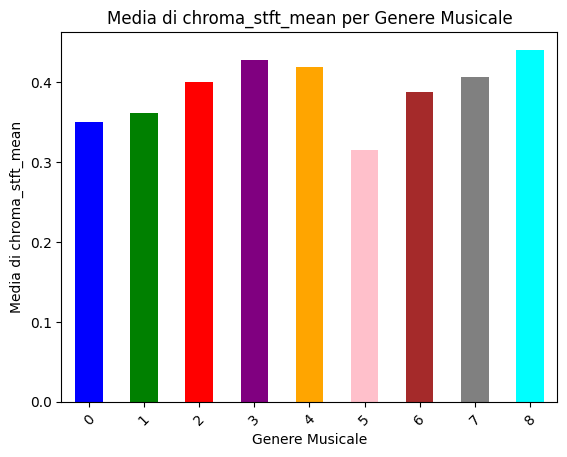

chroma_cqt_mean


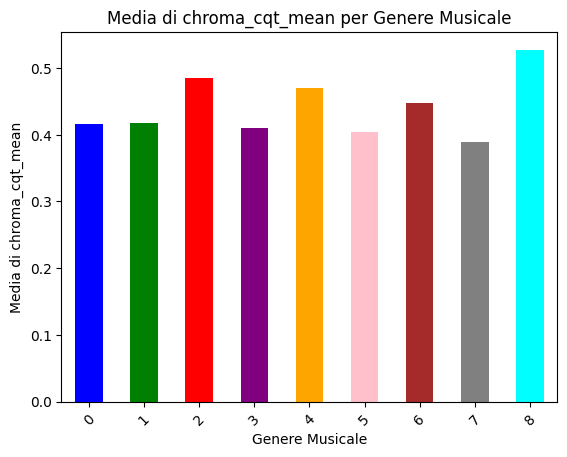

chroma_cens_mean


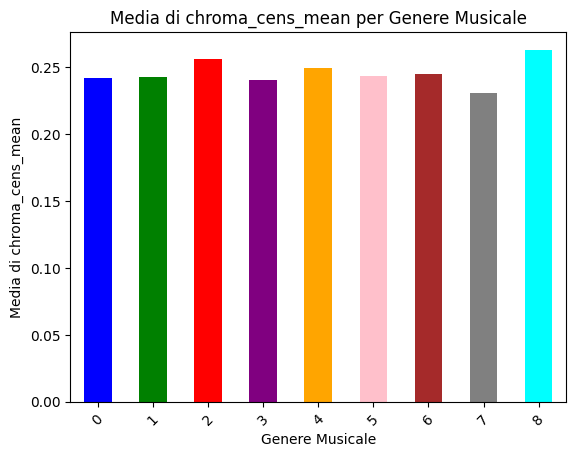

melspectrogram_mean


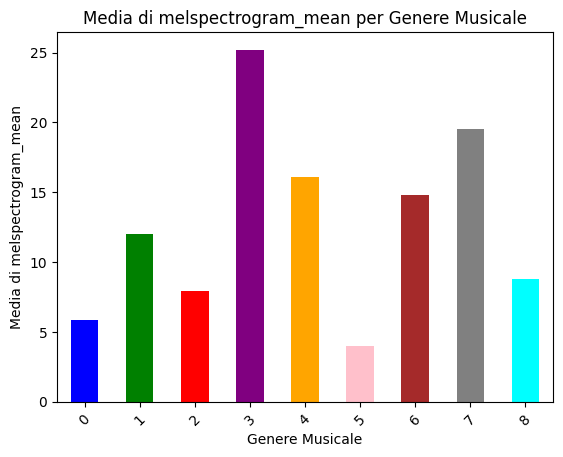

mfcc_mean


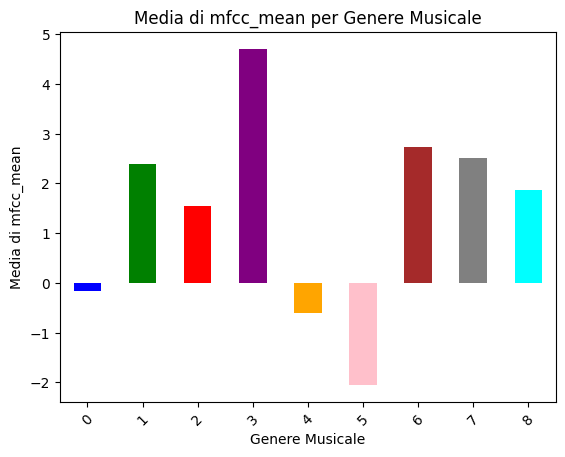

rms_mean


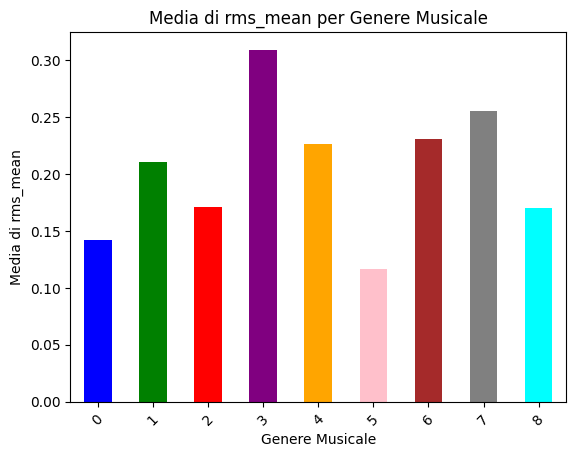

spectral_centroid_mean


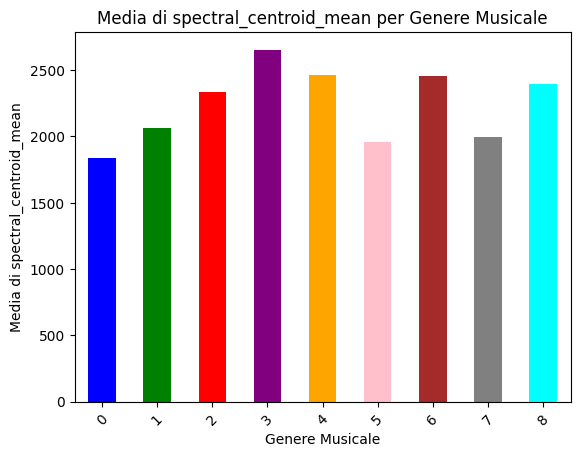

spectral_bandwidth_mean


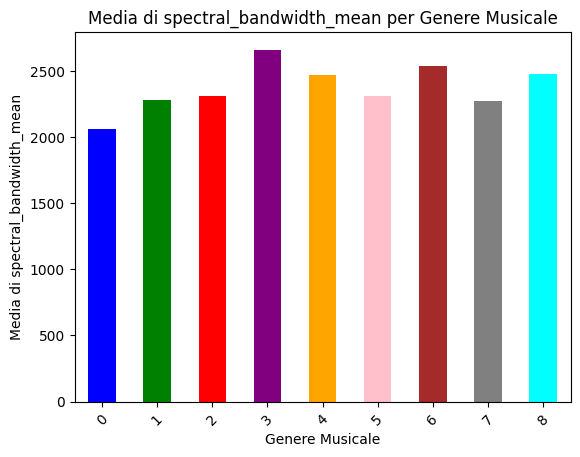

spectral_contrast_mean


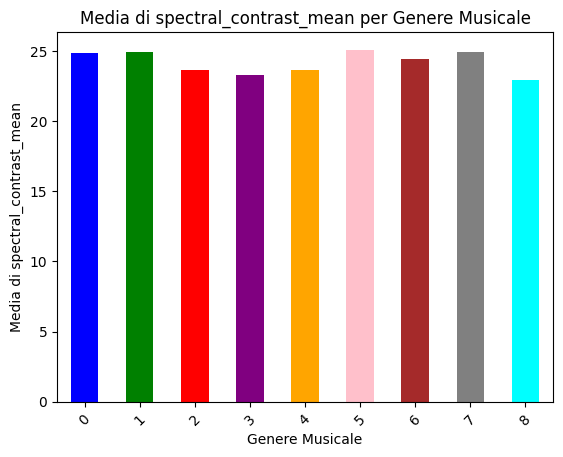

spectral_flatness_mean


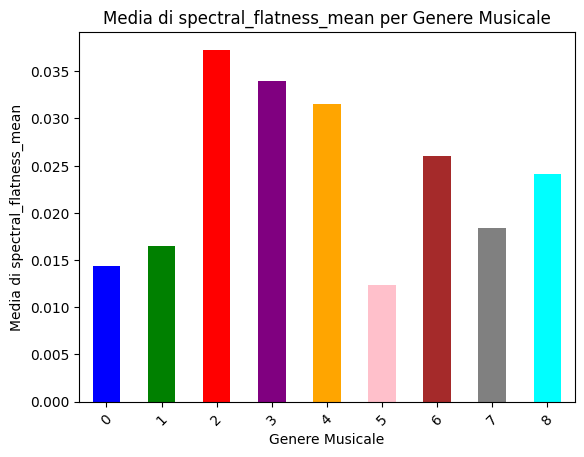

spectral_rolloff_mean


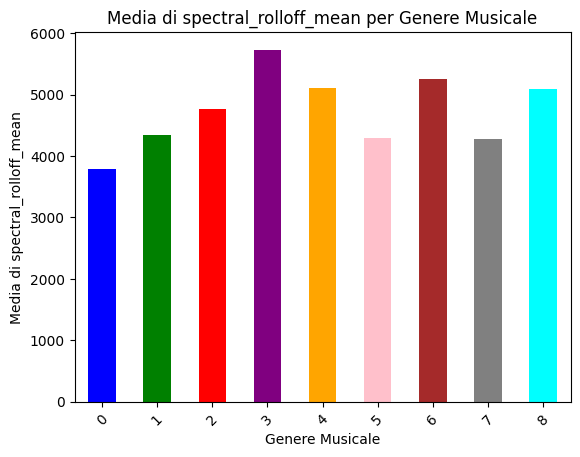

poly_features_mean


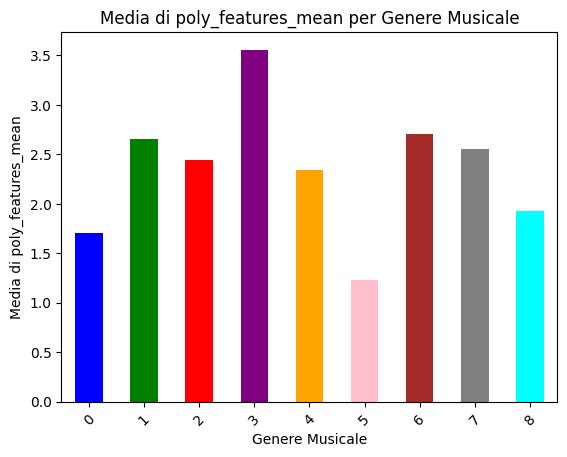

tonnetz_mean


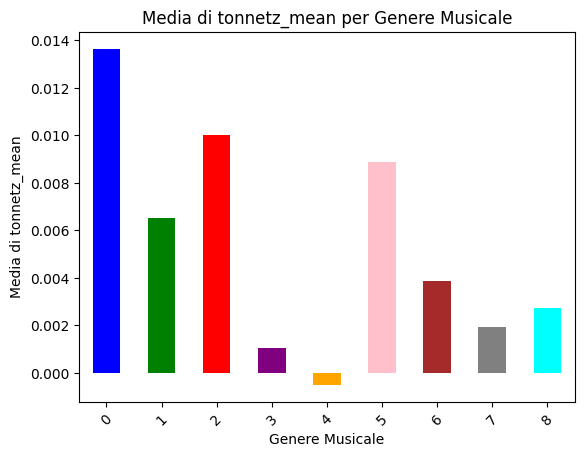

zero_crossing_rate_mean


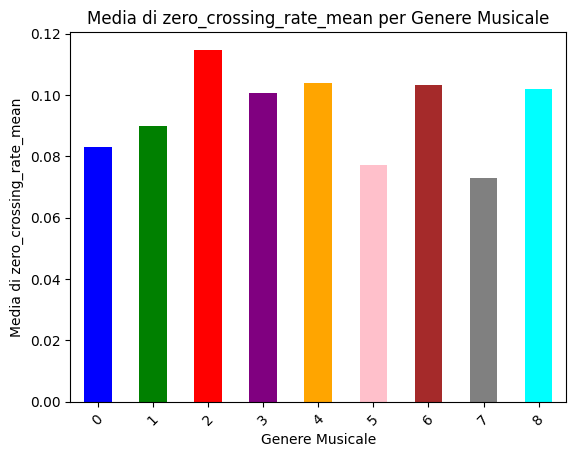

plp_mean


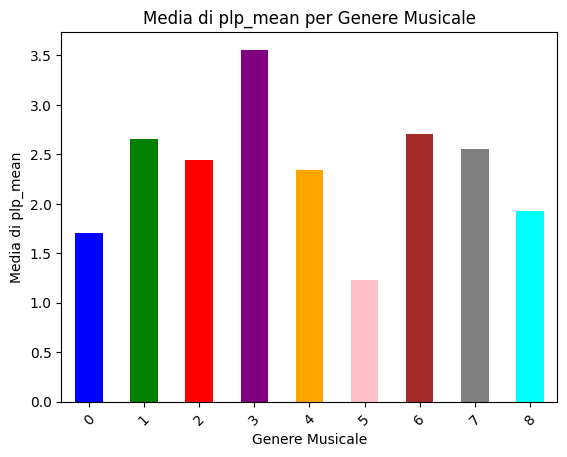

tempogram_mean


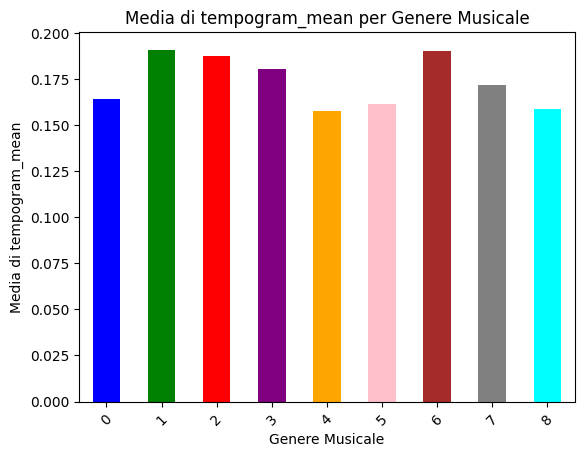

tempogram_ratio_mean


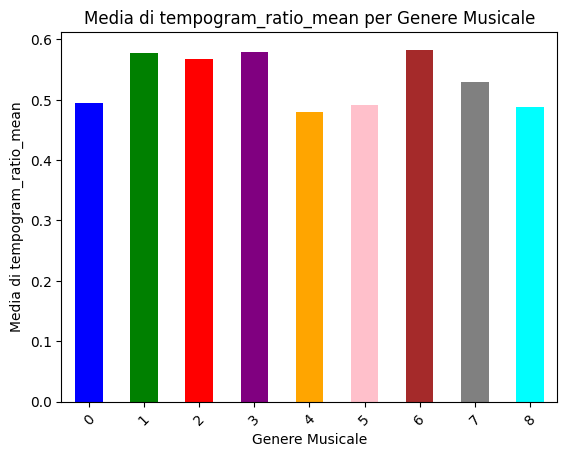

chroma_stft_var


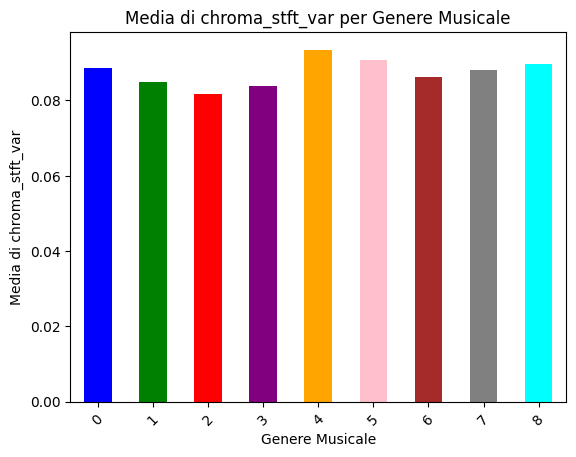

chroma_cqt_var


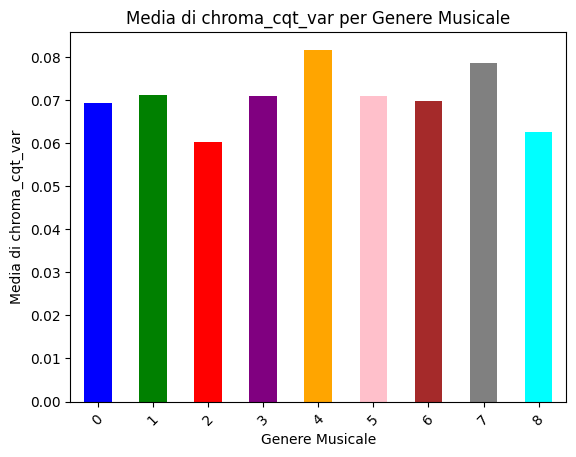

chroma_cens_var


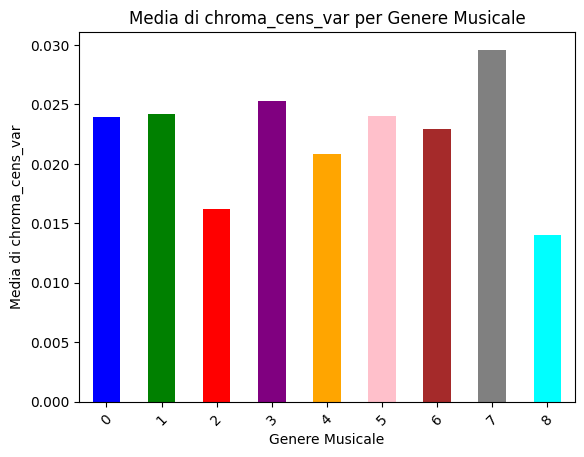

melspectrogram_var


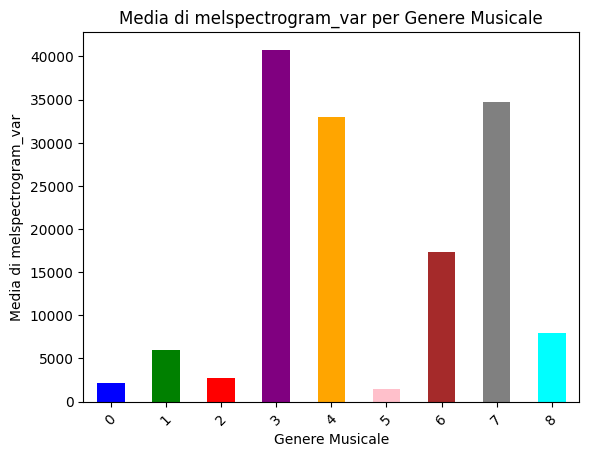

mfcc_var


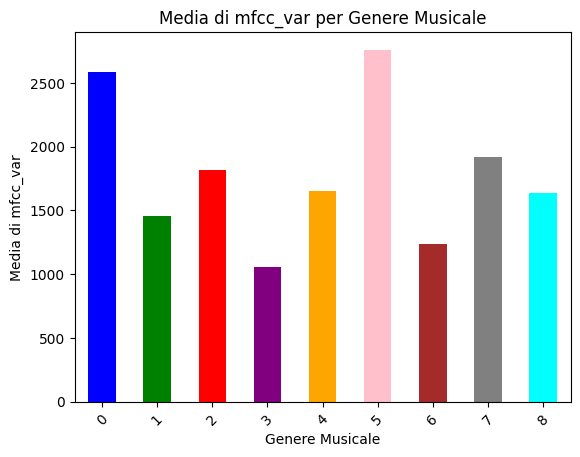

rms_var


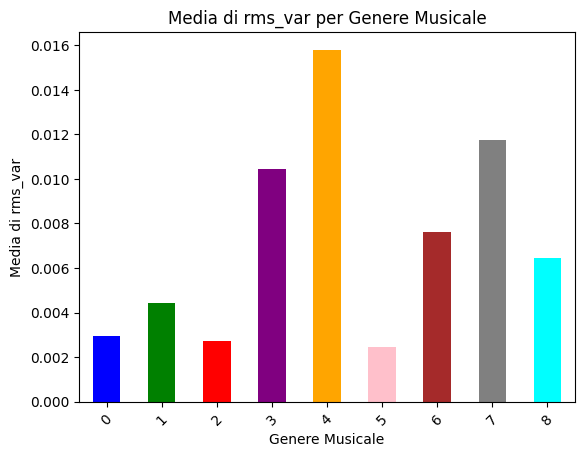

spectral_centroid_var


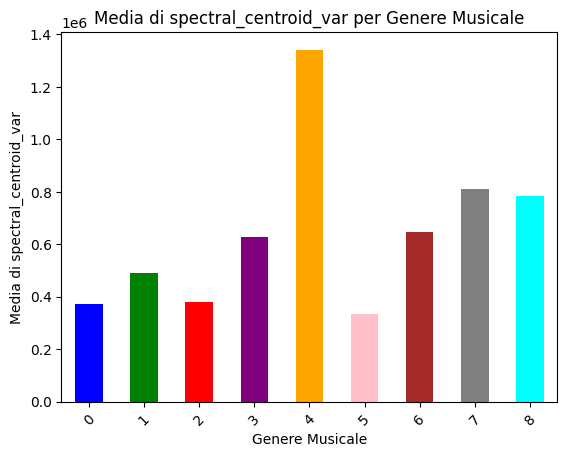

spectral_bandwidth_var


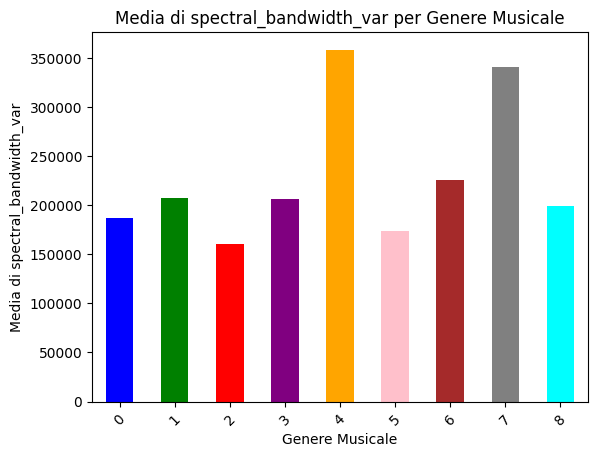

spectral_contrast_var


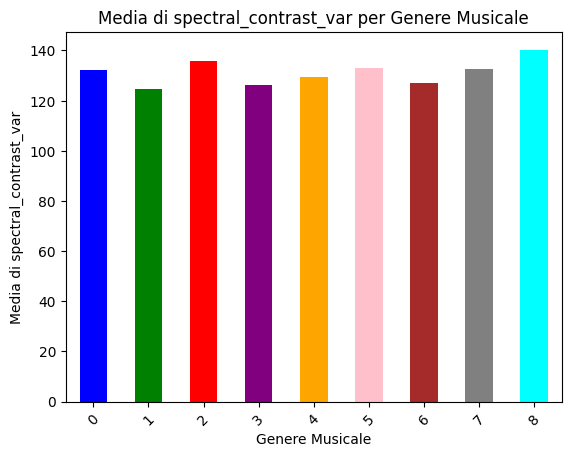

spectral_flatness_var


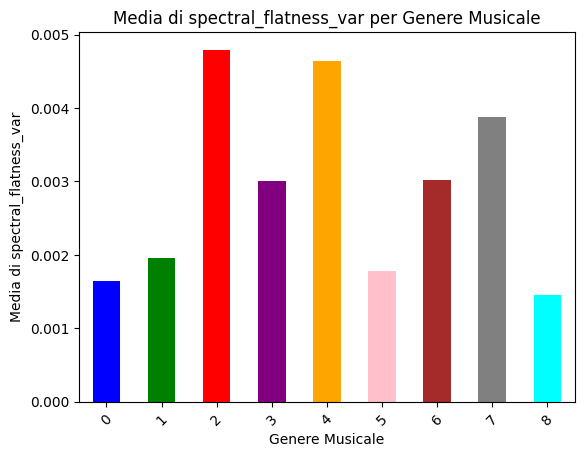

spectral_rolloff_var


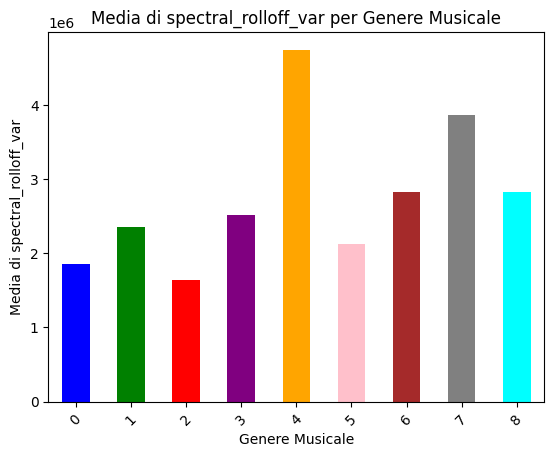

poly_features_var


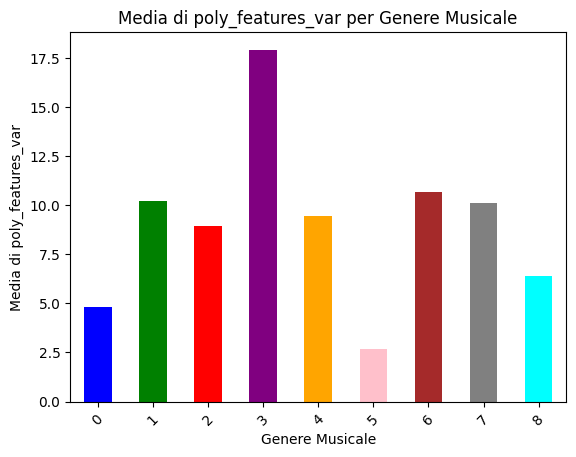

tonnetz_var


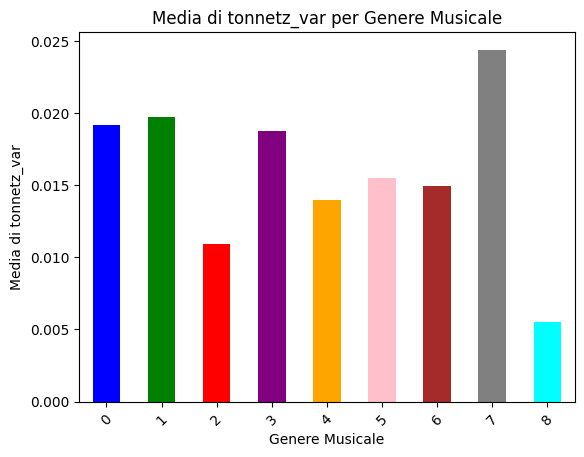

zero_crossing_rate_var


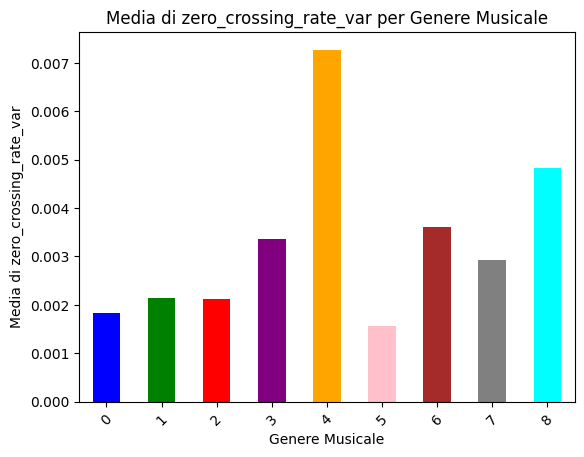

beat_track


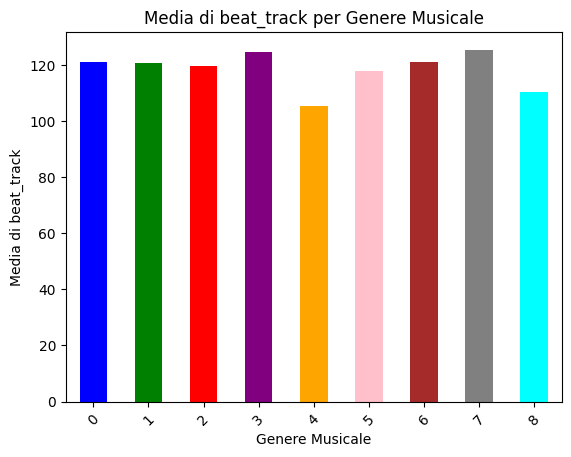

plp_var


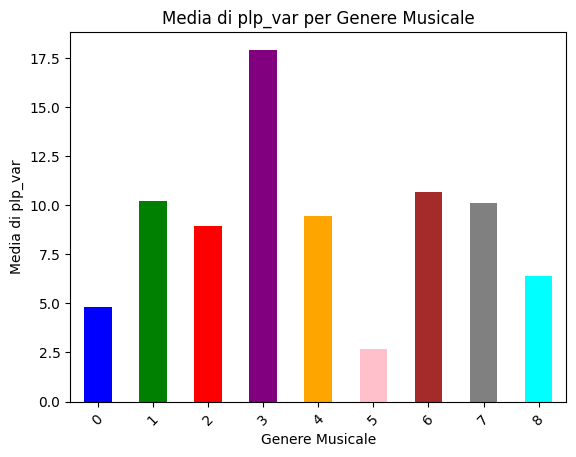

tempo


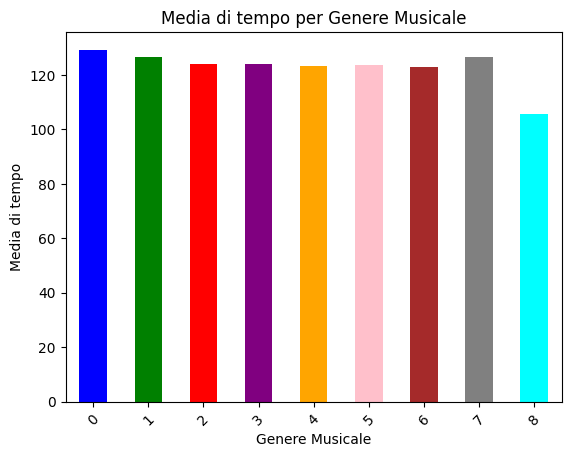

tempogram_var


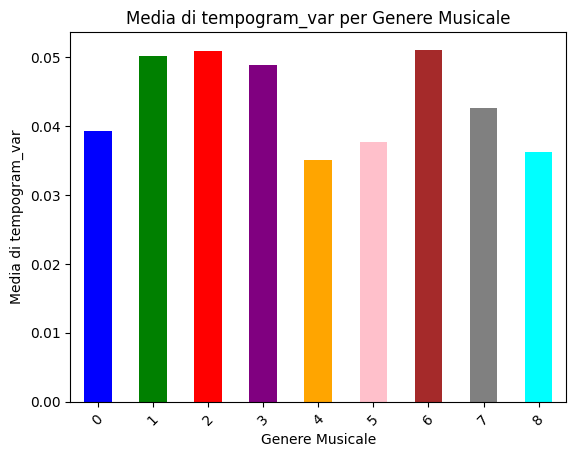

fourier_tempogram_var


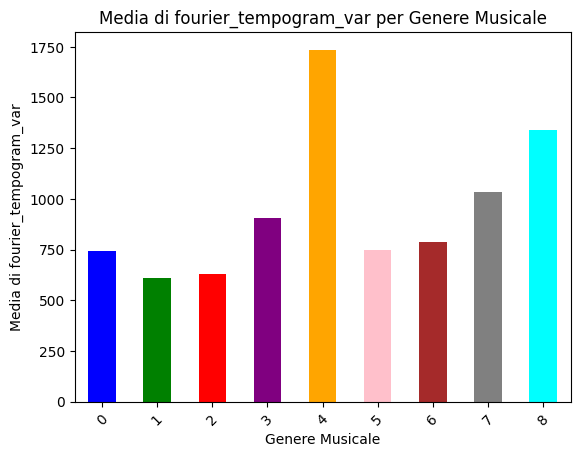

tempogram_ratio_var


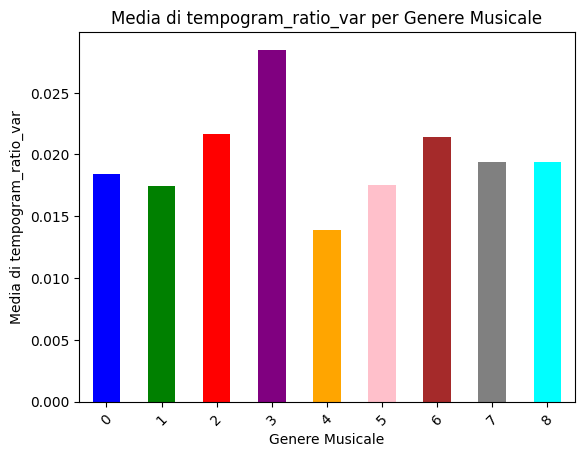

length


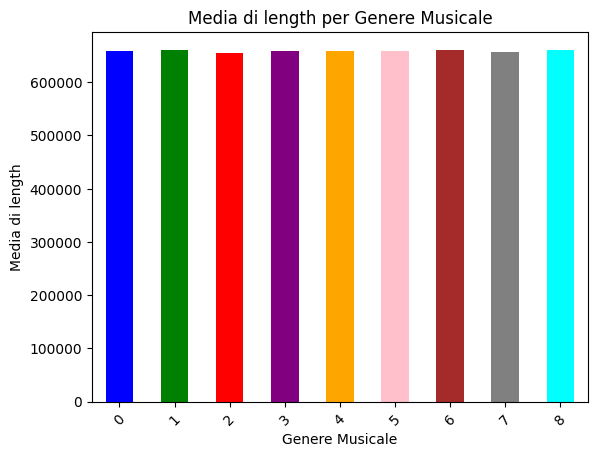

In [71]:
import pandas as pd
import matplotlib.pyplot as plt


# Lista delle colonne di interesse
features = columns[1:-1]

# Calcola le medie per ogni genere
genre_avg_dict = {}
for column in features:
    genre_avg = dataset.groupby("genre")[column].mean()
    genre_avg_dict[column] = genre_avg

# Calcola la variazione percentuale tra le medie di ogni colonna
variance_threshold = 20  # Imposta la soglia di variazione percentuale desiderata
significant_variances = []
no_significant_variances = []

for column, genre_avg in genre_avg_dict.items():
    max_variance = genre_avg.max() - genre_avg.min()
    average_variance = max_variance / genre_avg.mean() * 100

    if average_variance > variance_threshold:
        significant_variances.append(column)
    else:
      no_significant_variances.append(column)
    print(column)
    plt.figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
    genre_avg_dict[column].plot(kind="bar", color=colors)
    plt.title(f"Media di {column} per Genere Musicale")
    plt.xlabel("Genere Musicale")
    plt.ylabel(f"Media di {column}")
    plt.xticks(rotation=45)
    plt.show()

# Crea il barplot per le colonne con variazioni significative
# for column in significant_variances:
#     plt.figure(figsize=(5, 5))
#     colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
#     genre_avg_dict[column].plot(kind="bar", color=colors)
#     plt.title(f"Media di {column} per Genere Musicale")
#     plt.xlabel("Genere Musicale")
#     plt.ylabel(f"Media di {column}")
#     plt.xticks(rotation=45)
#     plt.show()

# # Crea il barplot per le colonne con variazioni NON significative
# for column in no_significant_variances:
#     plt.figure(figsize=(10, 5))
#     colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray']
#     genre_avg_dict[column].plot(kind="bar", color=colors)
#     plt.title(f"Media di {column} per Genere Musicale")
#     plt.xlabel("Genere Musicale")
#     plt.ylabel(f"Media di {column}")
#     plt.xticks(rotation=45)
#     plt.show()

## Genre cardinality

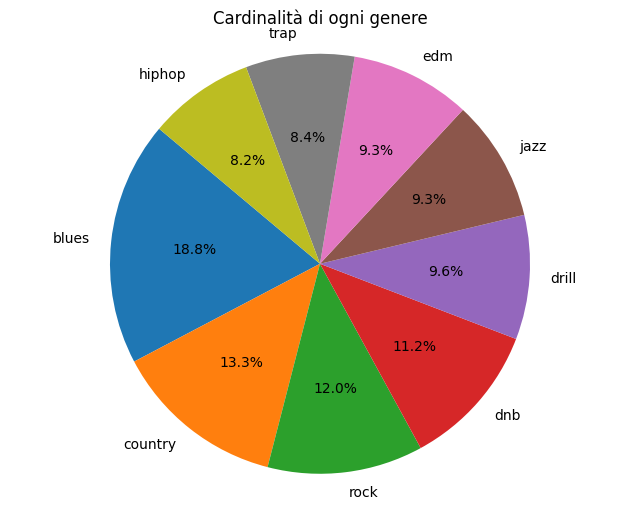

In [78]:
genre_counts = dataset["genre"].value_counts()

# Crea un grafico a torta
plt.figure(figsize=(8, 6))
plt.pie(genre_counts, labels=genre_labels, autopct="%1.1f%%", startangle=140)
plt.title("Cardinalità di ogni genere")
plt.axis("equal")  # Rende il grafico a torta circolare
plt.show()


# First feature selection

In [82]:
global selected_features

selected_features = [
'chroma_stft_mean',
  'chroma_cqt_mean',
  'chroma_cens_mean',
  'melspectrogram_mean',
  'mfcc_mean',
  'rms_mean',
  'spectral_centroid_mean',
  'spectral_bandwidth_mean',
  'spectral_contrast_mean',
  'spectral_flatness_mean',
  'spectral_rolloff_mean',
  'poly_features_mean',
  'tonnetz_mean',
  'zero_crossing_rate_mean',
  'plp_mean',
  'tempogram_mean',
  'tempogram_ratio_mean',
  'chroma_stft_var',
  'chroma_cqt_var',
  'chroma_cens_var',
  'melspectrogram_var',
  'mfcc_var',
  'rms_var',
  'spectral_centroid_var',
  'spectral_bandwidth_var',
  'spectral_contrast_var',
  'spectral_flatness_var',
  'spectral_rolloff_var',
  'poly_features_var',
  'tonnetz_var',
  'zero_crossing_rate_var',
  'beat_track',
  'plp_var',
  'tempo',
  'tempogram_var',
  'fourier_tempogram_var',
  'tempogram_ratio_var'
]

columns = [
  'title',
  'chroma_stft_mean',
  'chroma_cqt_mean',
  'chroma_cens_mean',
  'melspectrogram_mean',
  'mfcc_mean',
  'rms_mean',
  'spectral_centroid_mean',
  'spectral_bandwidth_mean',
  'spectral_contrast_mean',
  'spectral_flatness_mean',
  'spectral_rolloff_mean',
  'poly_features_mean',
  'tonnetz_mean',
  'zero_crossing_rate_mean',
  'plp_mean',
  'tempogram_mean',
  'tempogram_ratio_mean',
  'chroma_stft_var',
  'chroma_cqt_var',
  'chroma_cens_var',
  'melspectrogram_var',
  'mfcc_var',
  'rms_var',
  'spectral_centroid_var',
  'spectral_bandwidth_var',
  'spectral_contrast_var',
  'spectral_flatness_var',
  'spectral_rolloff_var',
  'poly_features_var',
  'tonnetz_var',
  'zero_crossing_rate_var',
  'beat_track',
  'plp_var',
  'tempo',
  'tempogram_var',
  'fourier_tempogram_var',
  'tempogram_ratio_var',
  'length',
  'genre'
]

features = columns[1:-1]

# Crea i widget Checkbox per ogni feature
feature_checkboxes = [widgets.Checkbox(value=True if feature in selected_features else False, description=feature) for feature in features]

# Funzione per aggiornare la lista delle feature selezionate
def update_selected_features(change):
    global selected_features
    selected_features = [checkbox.description for checkbox in feature_checkboxes if checkbox.value]
    print(selected_features)
# Collega la funzione all'evento di cambio di valore dei Checkbox
for checkbox in feature_checkboxes:
    checkbox.observe(update_selected_features, names='value')

# Crea un VBox con tutti i Checkbox
checkboxes_vbox = widgets.VBox(feature_checkboxes)

# Mostra i checkbox
display(checkboxes_vbox)



# Target variable and predictors

In [83]:
# Converto la variabile genre in intero
genre_labels = ['blues', 'country', 'rock', 'dnb', 'drill', 'jazz','edm','trap', 'hiphop']
genre_map = {genre_labels[i]: i for i in range(len(genre_labels))}
dataset['genre'] = dataset['genre'].map(genre_map)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6163 entries, 0 to 6162
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    6163 non-null   object 
 1   chroma_stft_mean         6163 non-null   float64
 2   chroma_cqt_mean          6163 non-null   float64
 3   chroma_cens_mean         6163 non-null   float64
 4   melspectrogram_mean      6163 non-null   float64
 5   mfcc_mean                6163 non-null   float64
 6   rms_mean                 6163 non-null   float64
 7   spectral_centroid_mean   6163 non-null   float64
 8   spectral_bandwidth_mean  6163 non-null   float64
 9   spectral_contrast_mean   6163 non-null   float64
 10  spectral_flatness_mean   6163 non-null   float64
 11  spectral_rolloff_mean    6163 non-null   float64
 12  poly_features_mean       6163 non-null   float64
 13  tonnetz_mean             6163 non-null   float64
 14  zero_crossing_rate_mean 

In [14]:
X, y = dataset[selected_features], dataset["genre"]

print(X.info())
print(y.info())
print(y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6163 entries, 0 to 6162
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         6163 non-null   float64
 1   chroma_cqt_mean          6163 non-null   float64
 2   chroma_cens_mean         6163 non-null   float64
 3   melspectrogram_mean      6163 non-null   float64
 4   mfcc_mean                6163 non-null   float64
 5   rms_mean                 6163 non-null   float64
 6   spectral_centroid_mean   6163 non-null   float64
 7   spectral_bandwidth_mean  6163 non-null   float64
 8   spectral_contrast_mean   6163 non-null   float64
 9   spectral_flatness_mean   6163 non-null   float64
 10  spectral_rolloff_mean    6163 non-null   float64
 11  poly_features_mean       6163 non-null   float64
 12  tonnetz_mean             6163 non-null   float64
 13  zero_crossing_rate_mean  6163 non-null   float64
 14  plp_mean                

# Classification

## Usefull functions

In [15]:
def plot_confusion_matrix(cm):
  genre_labels = ['blues', 'country', 'rock', 'dnb', 'drill', 'jazz','edm','trap', 'hiphop']
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap="Blues",xticklabels=genre_labels, yticklabels=genre_labels, fmt="d")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()


## Test set and training set

In [17]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)


In [21]:
# @title Feature scaling
global scale_features
scale_features = False # @param {type:"boolean"}


if scale_features==True:
  scaling_mode_dropdown = widgets.Dropdown(
      options=['Standardization', 'Normalization'],
      value='Standardization',
      description='Scaling Mode:',
      style={'description_width': 'initial'}  # Imposta la larghezza della descrizione come 'initial'

  )
  display(scaling_mode_dropdown)

  # Add an "Run" button for user interaction
  run_button = widgets.Button(description="Scale data")
  display(run_button)

  def on_run_button_click(b):
      global selected_scaling_mode
      selected_scaling_mode = scaling_mode_dropdown.value

      if selected_scaling_mode == 'Standardization':
          scaler = StandardScaler()
      elif selected_scaling_mode == 'Normalization':
          scaler = MinMaxScaler()

      global X_train_prepared
      X_train_prepared = scaler.fit_transform(X_train)
      global X_test_prepared
      X_test_prepared = scaler.fit_transform(X_test)
      print(X_train_prepared)

  run_button.on_click(on_run_button_click)

else:
  X_train_prepared = X_train
  X_test_prepared = X_test



# Evaluation metrics used

* Accuracy:
* Precision:
* Recall:
* F1-score:

# OneVsRestClassifier for Multi-Class Classification

One-vs-rest (OvR for short, also referred to as One-vs-All or OvA) is a heuristic method for using binary classification algorithms for multi-class classification.

It involves splitting the multi-class dataset into multiple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

In [22]:
if scale_features==False:
  X_train_prepared = X_train_prepared.values
  X_test_prepared = X_test_prepared.values
y_train = y_train.values
y_test = y_test.values

In [23]:
models_accuracy = {} # For the final models comparison summary

## Rige Regressor (classifier variant)



RidgeClassifier

* Converts binary targets to {-1, 1}.
* Treats classification as a regression task.
* Class prediction based on the sign of the regressor's prediction.
* For multi-class problems, it's treated as multi-output regression.
* Predicted class corresponds to the highest output value.
* Offers flexibility in choosing numerical solvers.
* Different solvers affect computational performance.
* Faster with many classes due to single matrix computation.
* Sometimes referred to as Least Squares Support Vector Machine with a linear kernel.

In [24]:
tic = time.time()
ovr_ridge_classifier = OneVsRestClassifier(RidgeClassifier())
ovr_ridge_classifier.fit(X_train_prepared, y_train)
ovr_ridge_y_pred = ovr_ridge_classifier.predict(X_test_prepared)
toc = time.time()
ridge_time = round(toc - tic, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.0444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.0444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.0444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.0444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: I

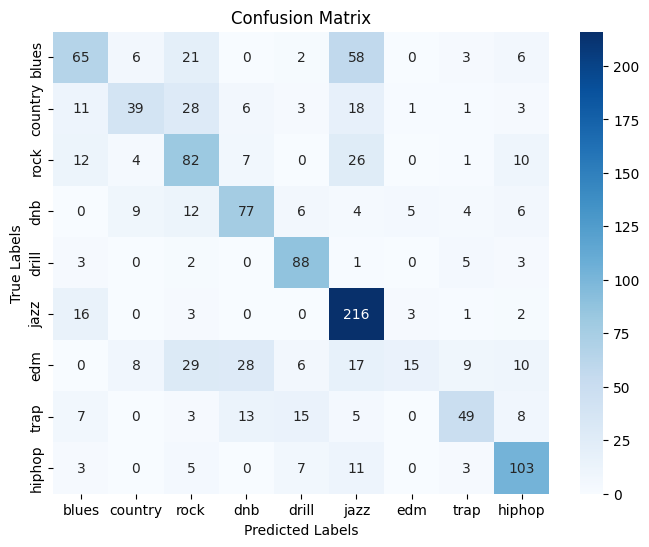

              precision    recall  f1-score   support

           0       0.56      0.40      0.47       161
           1       0.59      0.35      0.44       110
           2       0.44      0.58      0.50       142
           3       0.59      0.63      0.61       123
           4       0.69      0.86      0.77       102
           5       0.61      0.90      0.72       241
           6       0.62      0.12      0.21       122
           7       0.64      0.49      0.56       100
           8       0.68      0.78      0.73       132

    accuracy                           0.60      1233
   macro avg       0.60      0.57      0.56      1233
weighted avg       0.60      0.60      0.57      1233



In [25]:
ovr_ridge_cm = confusion_matrix(y_test, ovr_ridge_y_pred)
models_accuracy['ridge_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_ridge_y_pred, y_true=y_test), 2)}\nTime: {ridge_time}"
plot_confusion_matrix(ovr_ridge_cm)
print(classification_report(y_test, ovr_ridge_y_pred))

### Setting the regularization parameter
Leave-one-out Cross-Validation

In [26]:
import numpy as np
from sklearn import linear_model
reg = linear_model.RidgeCV()
reg.fit(X_train.values, y_train)
reg.alpha_

0.1

## SVM - classifier version (SVC)

In [27]:
tic = time.time()
ovr_svm_classifier = svm.SVC(decision_function_shape='ovr')
ovr_svm_classifier.fit(X_train_prepared, y_train)
ovr_svm_y_pred = ovr_svm_classifier.predict(X_test_prepared)
toc = time.time()
svm_time = round(toc-tic,2)


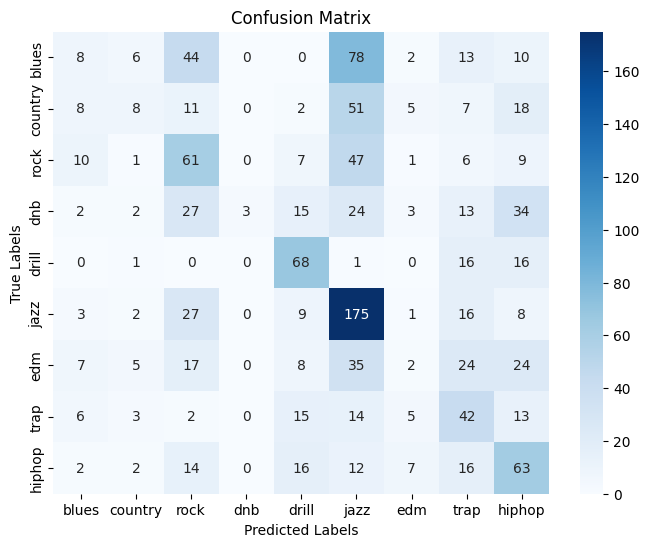

              precision    recall  f1-score   support

           0       0.17      0.05      0.08       161
           1       0.27      0.07      0.11       110
           2       0.30      0.43      0.35       142
           3       1.00      0.02      0.05       123
           4       0.49      0.67      0.56       102
           5       0.40      0.73      0.52       241
           6       0.08      0.02      0.03       122
           7       0.27      0.42      0.33       100
           8       0.32      0.48      0.39       132

    accuracy                           0.35      1233
   macro avg       0.37      0.32      0.27      1233
weighted avg       0.36      0.35      0.28      1233



In [28]:
ovr_svm_test_cm = confusion_matrix(y_test, ovr_svm_y_pred)
plot_confusion_matrix(ovr_svm_test_cm)
models_accuracy['svm_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_svm_y_pred, y_true=y_test), 2)}\nTime: {svm_time}"
print(classification_report(y_test, ovr_svm_y_pred))

## K-Nearest Neighbors

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

scikit-learn implements two different nearest neighbors classifiers: KNeighborsClassifier implements learning based on the
 nearest neighbors of each query point, where
 is an integer value specified by the user. RadiusNeighborsClassifier implements learning based on the number of neighbors within a fixed radius
 of each training point, where
 is a floating-point value specified by the user.

The
-neighbors classification in KNeighborsClassifier is the most commonly used technique. The optimal choice of the value
 is highly data-dependent: in general a larger
 suppresses the effects of noise, but makes the classification boundaries less distinct.

In cases where the data is not uniformly sampled, radius-based neighbors classification in RadiusNeighborsClassifier can be a better choice. The user specifies a fixed radius
, such that points in sparser neighborhoods use fewer nearest neighbors for the classification. For high-dimensional parameter spaces, this method becomes less effective due to the so-called “curse of dimensionality”.

The basic nearest neighbors classification uses uniform weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the weights keyword. The default value, weights = 'uniform', assigns uniform weights to each neighbor. weights = 'distance' assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied to compute the weights.

In [29]:
tic = time.time()
ovr_knn_classifier = OneVsRestClassifier(KNeighborsClassifier())
ovr_knn_classifier.fit(X_train_prepared, y_train)
ovr_knn_y_pred = ovr_knn_classifier.predict(X_test_prepared)
ovr_knn_pred_proba = ovr_knn_classifier.predict_proba(X_test_prepared)
toc = time.time()
knn_time = round(toc - tic, 2)

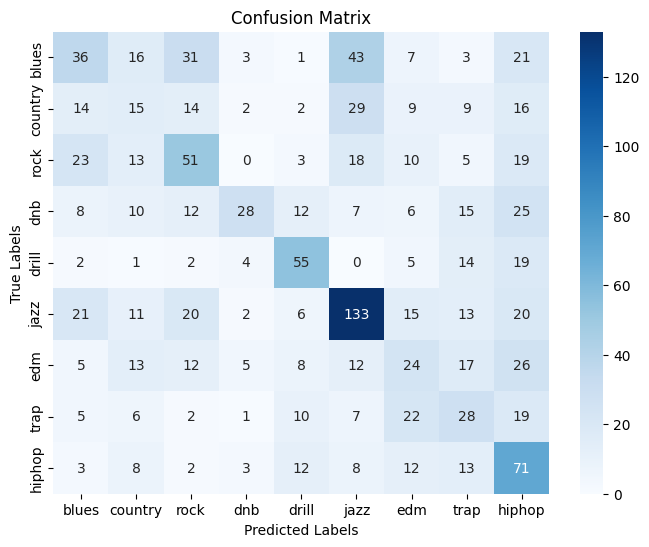

              precision    recall  f1-score   support

           0       0.31      0.22      0.26       161
           1       0.16      0.14      0.15       110
           2       0.35      0.36      0.35       142
           3       0.58      0.23      0.33       123
           4       0.50      0.54      0.52       102
           5       0.52      0.55      0.53       241
           6       0.22      0.20      0.21       122
           7       0.24      0.28      0.26       100
           8       0.30      0.54      0.39       132

    accuracy                           0.36      1233
   macro avg       0.35      0.34      0.33      1233
weighted avg       0.37      0.36      0.35      1233



In [30]:
ovr_knn_test_cm = confusion_matrix(y_true=y_test, y_pred=ovr_knn_y_pred)
plot_confusion_matrix(ovr_knn_test_cm)
models_accuracy['knn_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_knn_y_pred, y_true=y_test), 2)}\nTime: {knn_time}"
print(classification_report(y_test, ovr_knn_y_pred))

## Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.
Some advantages of decision trees are:

Simple to understand and to interpret. Trees can be visualized.

Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.

The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.

Able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.

Able to handle multi-output problems.

Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations as seen in the above figure. Therefore, they are not good at extrapolation.

The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.

Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

1.10.1. Classification

In [31]:
# tic = time.time()
# ovr_dt_classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())
# ovr_dt_classifier.fit(X_train_prepared, y_train)
# ovr_dt_y_pred = ovr_dt_classifier.predict(X_test_prepared)
# ovr_dt_pred_proba = ovr_dt_classifier.predict_proba(X_test_prepared)
# toc = time.time()
# dt_time = round(toc - tic, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [104]:
tic = time.time()
ovr_dt_classifier = OneVsRestClassifier(DecisionTreeClassifier()) # n_estimators = 100 (default)
ovr_dt_classifier.fit(X_train_prepared, y_train)
ovr_dt_y_pred = ovr_dt_classifier.predict(X_test_prepared)
ovr_dt_pred_proba = ovr_dt_classifier.predict_proba(X_test_prepared)
toc = time.time()
rf_time = round(toc - tic, 2)

[8 4 6 ... 8 3 7]


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


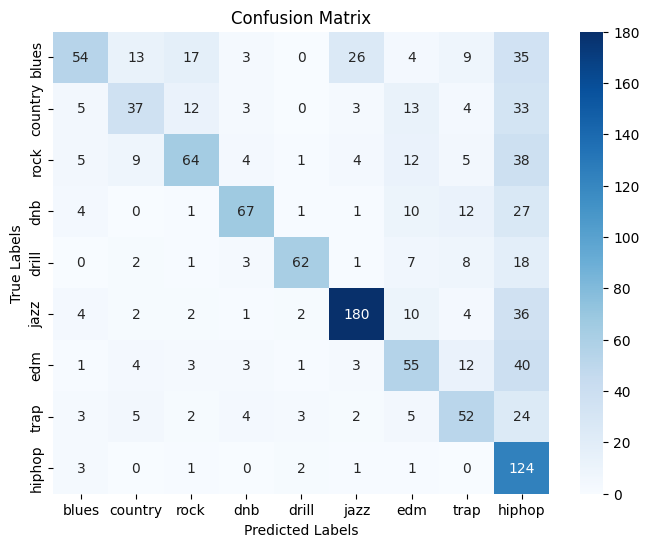

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       161
           1       0.51      0.34      0.41       110
           2       0.62      0.45      0.52       142
           3       0.76      0.54      0.64       123
           4       0.86      0.61      0.71       102
           5       0.81      0.75      0.78       241
           6       0.47      0.45      0.46       122
           7       0.49      0.52      0.50       100
           8       0.33      0.94      0.49       132

    accuracy                           0.56      1233
   macro avg       0.62      0.55      0.55      1233
weighted avg       0.63      0.56      0.57      1233



In [105]:
ovr_dt_cm = confusion_matrix(y_test, ovr_dt_y_pred)
plot_confusion_matrix(ovr_dt_cm)
models_accuracy['dt_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_dt_y_pred, y_true=y_test), 2)}\nTime: {dt_time}"
print(classification_report(y_test, ovr_dt_y_pred))


## Random Forest

In [34]:
tic = time.time()
ovr_rf_classifier = OneVsRestClassifier(RandomForestClassifier()) # n_estimators = 100 (default)
ovr_rf_classifier.fit(X_train_prepared, y_train)
ovr_rf_y_pred = ovr_rf_classifier.predict(X_test_prepared)
ovr_rf_pred_proba = ovr_rf_classifier.predict_proba(X_test_prepared)
toc = time.time()
rf_time = round(toc - tic, 2)


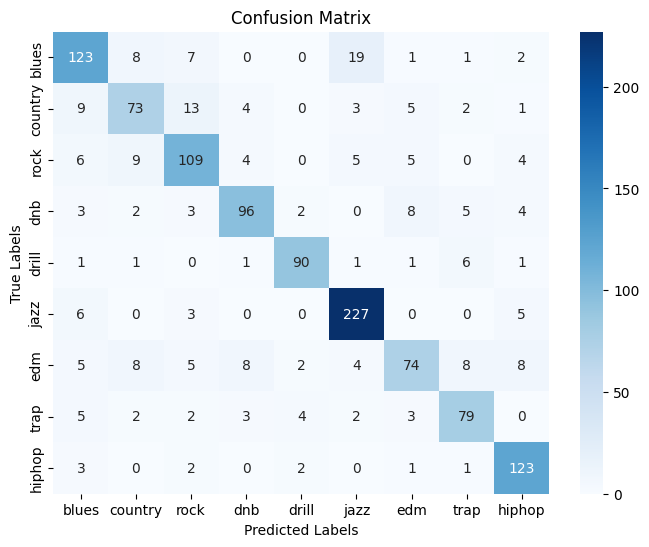

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       161
           1       0.71      0.66      0.69       110
           2       0.76      0.77      0.76       142
           3       0.83      0.78      0.80       123
           4       0.90      0.88      0.89       102
           5       0.87      0.94      0.90       241
           6       0.76      0.61      0.67       122
           7       0.77      0.79      0.78       100
           8       0.83      0.93      0.88       132

    accuracy                           0.81      1233
   macro avg       0.80      0.79      0.79      1233
weighted avg       0.80      0.81      0.80      1233



In [35]:
ovr_rf_cm = confusion_matrix(y_true=y_test, y_pred=ovr_rf_y_pred)
plot_confusion_matrix(ovr_rf_cm)
models_accuracy['rf_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_rf_y_pred, y_true=y_test), 2)}\nTime: {rf_time}"
print(classification_report(y_test, ovr_rf_y_pred))


## AdaBoost

The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire [FS1995].

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights
,
, …,
 to each of the training samples. Initially, those weights are all set to
, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].

AdaBoost can be used both for classification and regression problems:

For multi-class classification, AdaBoostClassifier implements AdaBoost-SAMME and AdaBoost-SAMME.R [ZZRH2009].

In [36]:
tic = time.time()
adaBoost_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),
    algorithm="SAMME",
    n_estimators=500
)

ovr_adaBoost_classifier = OneVsRestClassifier(adaBoost_classifier)
ovr_adaBoost_classifier.fit(X_train_prepared, y_train)
ovr_adaBoost_y_pred = ovr_adaBoost_classifier.predict(X_test_prepared)
toc = time.time()
adaBoost_time = round(toc - tic, 2)

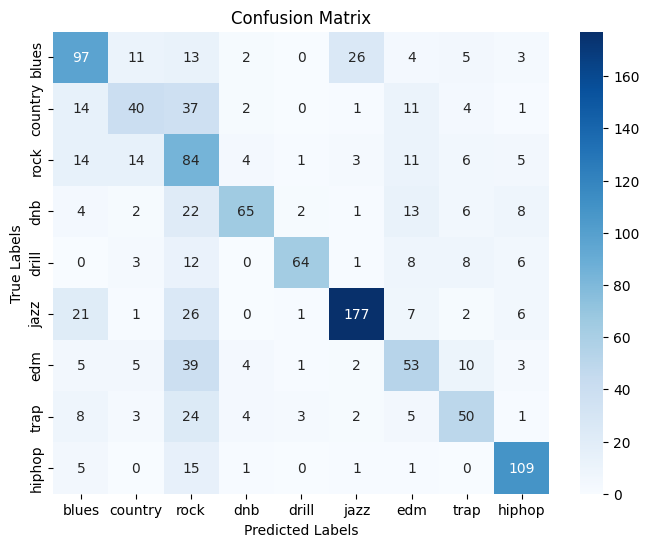

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       161
           1       0.51      0.36      0.42       110
           2       0.31      0.59      0.41       142
           3       0.79      0.53      0.63       123
           4       0.89      0.63      0.74       102
           5       0.83      0.73      0.78       241
           6       0.47      0.43      0.45       122
           7       0.55      0.50      0.52       100
           8       0.77      0.83      0.80       132

    accuracy                           0.60      1233
   macro avg       0.63      0.58      0.59      1233
weighted avg       0.64      0.60      0.61      1233



In [37]:
adaBoost_cm = confusion_matrix(y_test, ovr_adaBoost_y_pred)
plot_confusion_matrix(adaBoost_cm)
models_accuracy['adaBoost_classifier'] = f"Accuracy score: {round(accuracy_score(y_pred=ovr_adaBoost_y_pred, y_true=y_test), 2)}\nTime: {adaBoost_time}"
print(classification_report(y_test, ovr_adaBoost_y_pred))

# Models performance overview

In [38]:
models_performances = pd.DataFrame(columns=['Model','Accuracy','Time'])
data = []

for model_name, results in models_accuracy.items():
    accuracy = float(results.split('Accuracy score: ')[1].split()[0])
    model_time = float(results.split('Time: ')[1])
    data.append({'Model': model_name, 'Accuracy': accuracy, 'Time': model_time})

global models_performances
models_performances = pd.concat([models_performances, pd.DataFrame(data)], ignore_index=True)
models_performances_sorted = models_performances.sort_values(by=['Accuracy', 'Time'], ascending=[False, True])
print(models_performances_sorted)

                 Model  Accuracy    Time
4        rf_classifier      0.81   30.95
0     ridge_classifier      0.60    0.10
5  adaBoost_classifier      0.60  317.33
3        dt_classifier      0.57    2.17
2       knn_classifier      0.36    2.57
1       svm_classifier      0.35    3.23


# ROC curves


In [114]:
from numpy.ma.extras import average
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

class analyze_classifier:
    def __init__(self, classifier, X, y, y_score=np.array([])):
        if len(y_score)==0:
            try:
              self.y_score = classifier.decision_function(X)
            except:
                self.y_score = classifier.predict_proba(X)
        else:
          self_y_score = y_score


        self.X = X
        self.classifier = classifier
        self.y = y
        self.class_names = classifier.classes_
        self.y_binarized = label_binarize(y, classes=self.classifier.classes_)


        self.precision, self.recall, self.threshold, self.average_precision = self.get_precision_recall_classes()
        self.fpr, self.tpr, self.roc_auc = self.get_roc_auc_classes()
        self.colors = cycle(["blue", "green", "red", "purple", "orange", "cyan", "magenta", "yellow", "brown"])

        if hasattr(self.classifier, 'n_classes_'):
          print("")
        else:
          self.classifier.n_classes_ = len(self.classifier.classes_)
        # print("n_classes: ", self.classifier.n_classes_)

    def get_precision_recall_classes(self):
        precision = dict()
        recall = dict()
        average_precision = dict()
        threshold = dict()

        if hasattr(self.classifier, 'n_classes_'):
          print("")
        else:
          self.classifier.n_classes_ = len(self.classifier.classes_)
        # print("n_classes: ", self.classifier.n_classes_)

        for i in range(self.classifier.n_classes_):
            if np.isnan(self.y_score[:, i]).any():
              self.y_score[:, i][np.isnan(self.y_score[:, i])] = 0
            precision[i], recall[i], threshold[i] = precision_recall_curve(self.y_binarized[:, i], self.y_score[:, i])
            average_precision[i] = average_precision_score(self.y_binarized[:, i], self.y_score[:, i])

        # A 'micro-average' quantifying score on all classes jointly
        precision['micro'], recall['micro'], threshold['micro'] = precision_recall_curve(
            self.y_binarized.ravel(),
            self.y_score.ravel()
        )

        average_precision['micro'] = average_precision_score(self.y_binarized, self.y_score, average='micro')

        return precision, recall, threshold, average_precision

    def get_roc_auc_classes(self):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(self.class_names)):
            fpr[i], tpr[i], _ = roc_curve(self.y_binarized[:, i], self.y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y_binarized.ravel(), self.y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.classifier.n_classes_)]))
        mean_tpr = np.zeros_like(all_fpr)
        # Then interpolate all ROC curves at this points
        if hasattr(self.classifier, 'n_classes_'):
          print("")
        else:
          self.classifier.n_classes_ = len(self.classifier.classes_)
        # print("n_classes: ", self.classifier.n_classes_)

        for i in range(self.classifier.n_classes_):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= self.classifier.n_classes_
        # Finally average it and compute AUC
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        return fpr, tpr, roc_auc

    def plot_precision_recall_micro(self):
        _, ax = plt.subplots(figsize=(16, 8))
        display = PrecisionRecallDisplay(
            recall=self.recall["micro"],
            precision=self.precision["micro"],
            average_precision=self.average_precision["micro"]
            )
        display.plot(ax=ax)
        _ = display.ax_.set_title("Micro-averaged over all classes")

    def plot_precision_recall_classes(self):
          # setup plot details
          fig, ax = plt.subplots(figsize=(16, 9))
          f_scores = np.linspace(0.2, 0.8, num=4)
          lines, labels = [], []

          for f_score in f_scores:
              x = np.linspace(0.01, 1)
              y = f_score * x / (2 * x - f_score)
              ax.plot(x[y > 0], y[y > 0], color="gray", alpha=0.2)
              ax.annotate("f1={:.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

          PrecisionRecallDisplay(
              recall=self.recall["micro"],
              precision=self.precision["micro"],
              average_precision=self.average_precision["micro"],
          ).plot(ax=ax, name="Micro-average precision-recall", color="gold")

          for i, color in zip(range(self.classifier.n_classes_), self.colors):
              PrecisionRecallDisplay(
                  recall=self.recall[i],
                  precision=self.precision[i],
                  average_precision=self.average_precision[i],
              ).plot(ax=ax, name=f"Precision-recall for {genre_labels[i]}", color=color)

          # add the Legend for the iso-f1 curves
          handles, labels = ax.get_legend_handles_labels()
          handles.extend([1])
          labels.extend(["iso-f1 curves"])

          # set the Legend and the axes
          ax.set_xlim([0.0, 1.0])
          ax.set_ylim([0.0, 1.05])
          ax.legend(handles=handles, labels=labels, loc="best")
          ax.set_title("Extension of Precision-Recall curve to multi-class")
          plt.show()

    def plot_precision_recall_vs_threshold(self, classes_indexes=True):
              if classes_indexes == True:
                  classes_indexes = list(self.classifier.classes_)

              plt.figure(figsize=(16, 9))

              for c, color in zip(classes_indexes, self.colors):
                  plt.plot(
                      self.threshold[c],
                      self.precision[c][:-1],
                      "--",
                      label="Precision {}".format(genre_labels[int(c)]),
                      color=color,
                  )
                  plt.plot(
                      self.threshold[c],
                      self.recall[c][:-1],
                      "-",
                      label="Recall {}".format(genre_labels[int(c)]),
                      color=color,
                  )

              plt.xlabel("Threshold")
              plt.legend(loc="best")
              plt.title("Precision (--) and Recall (-) vs. Threshold Curve")
              plt.grid(visible=True)
              plt.show()

    def plot_roc_micro_macro(self):
        # micro and macro roc curve
        _, ax = plt.subplots(figsize=(16, 9))
        lw = 2
        ax.plot(
            self.fpr['micro'],
            self.tpr['micro'],
            lw=lw,
            label="ROC curve micro (area = %0.2f)" % self.roc_auc['micro']
        )
        ax.plot(
            self.fpr['macro'],
            self.tpr['macro'],
            lw=lw,
            label="ROC curve macro (area = %0.2f)" % self.roc_auc['macro']
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Receiver operating characteristic for {str(self.classifier)}")
        plt.legend(loc="lower right")
        plt.show()

    def plot_roc_classes(self):
        fig, ax = plt.subplots(figsize=(16, 9))
        lw = 2
        for c, color in zip(range(self.classifier.n_classes_), self.colors):
            ax.plot(
                self.fpr[c],
                self.tpr[c],
                color=color,
                lw=lw,
                label=f"ROC curve for {genre_labels[int(c)]} (area - %0.2f)" % (self.roc_auc[c])
            )
        ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"Receiver operating characteristic for each class ({str(self.classifier)})")
        ax.legend(loc="lower right")
        plt.show()



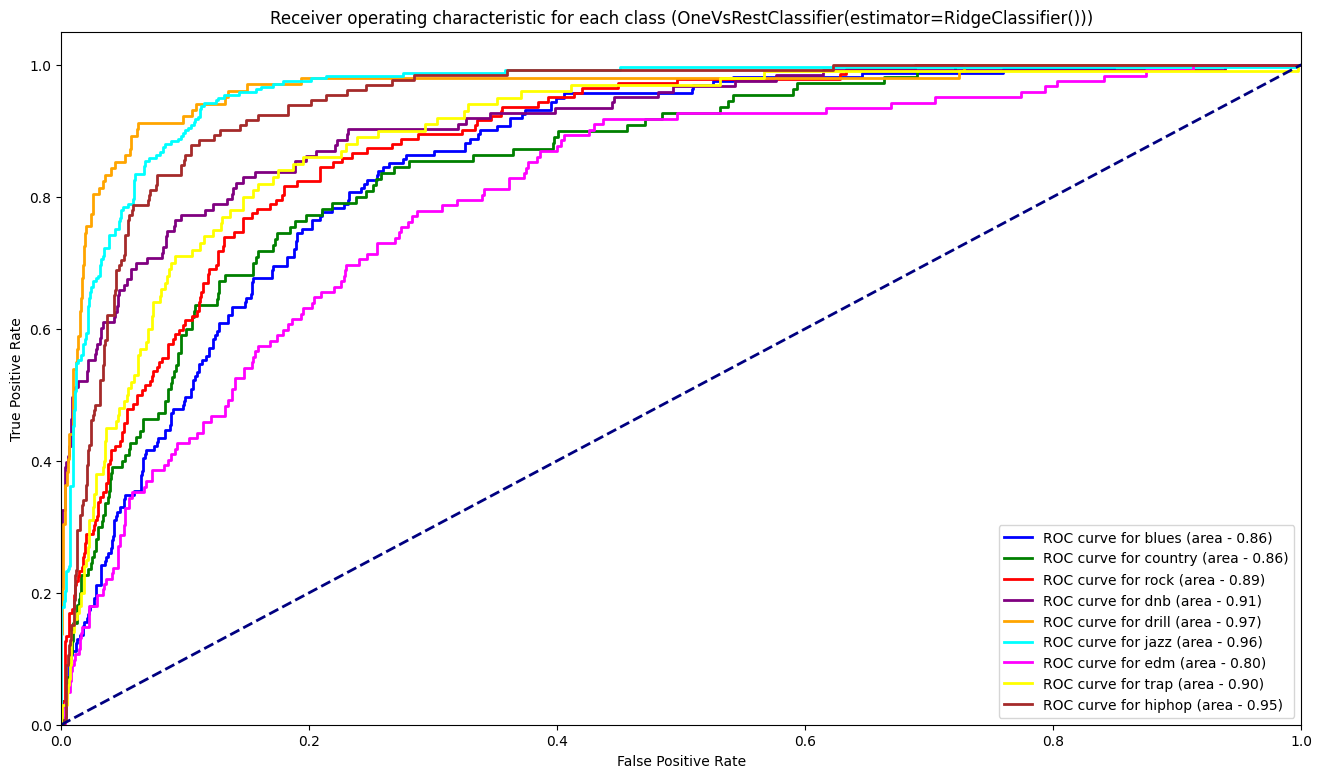

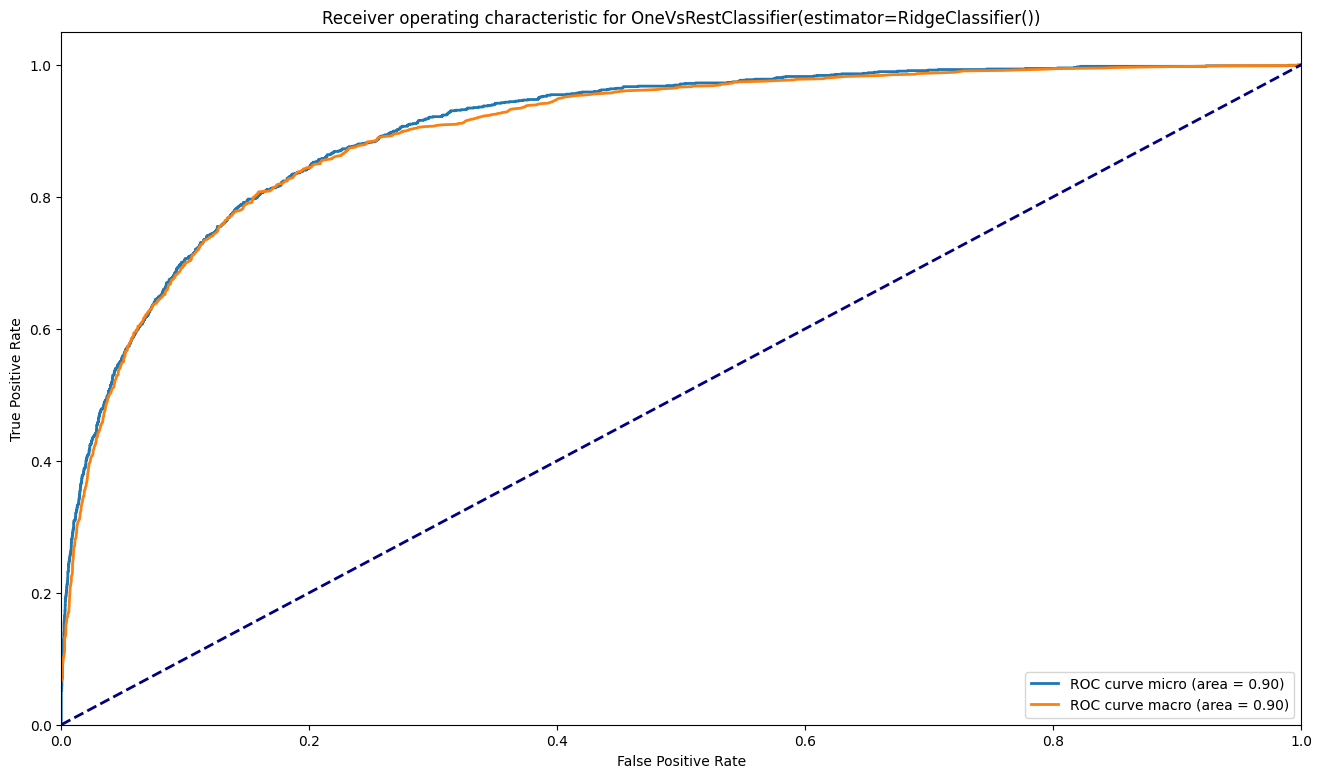

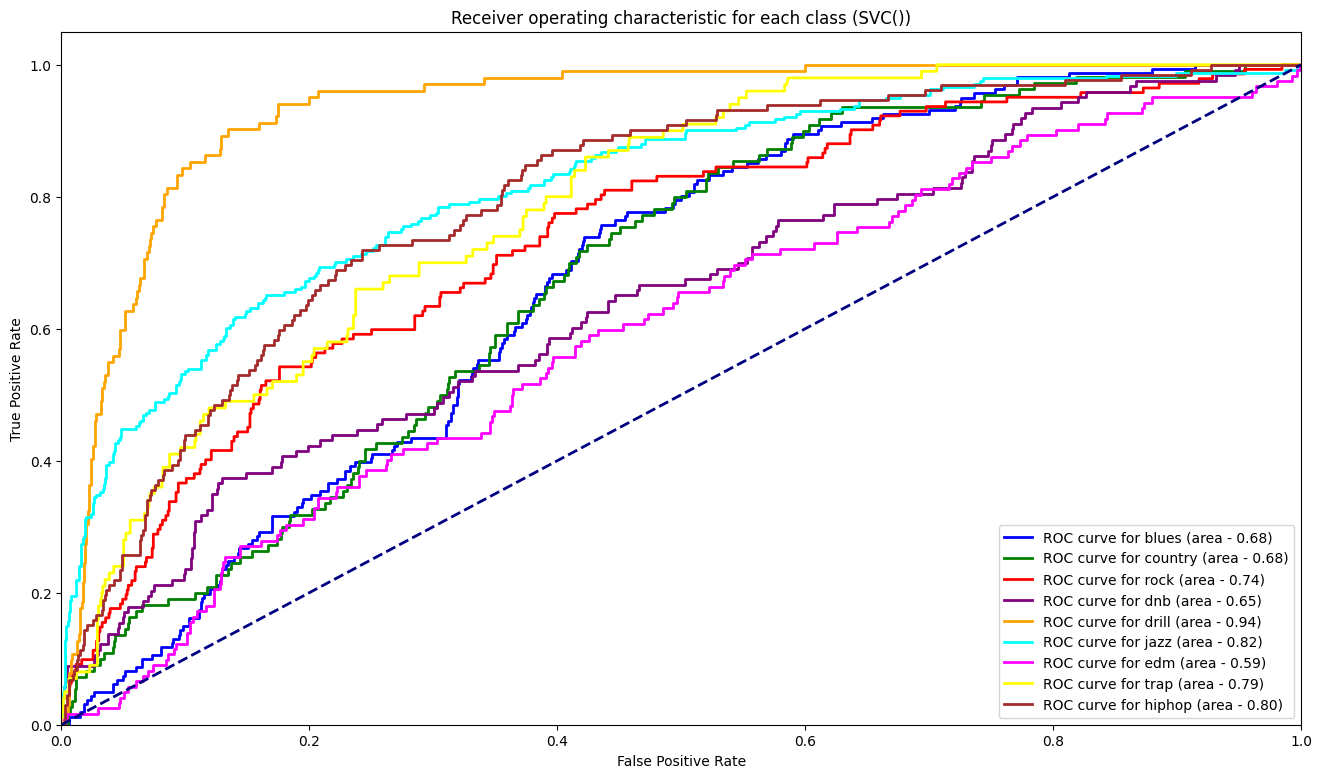

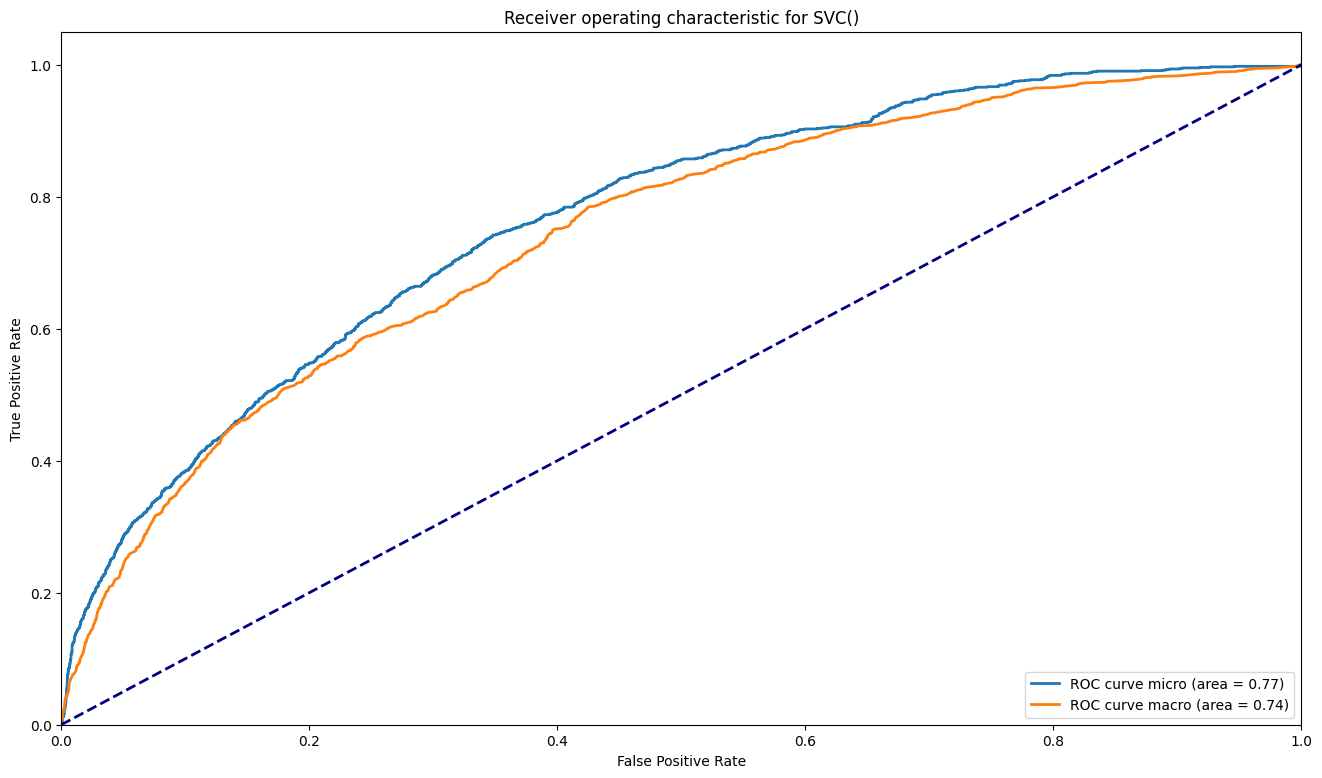

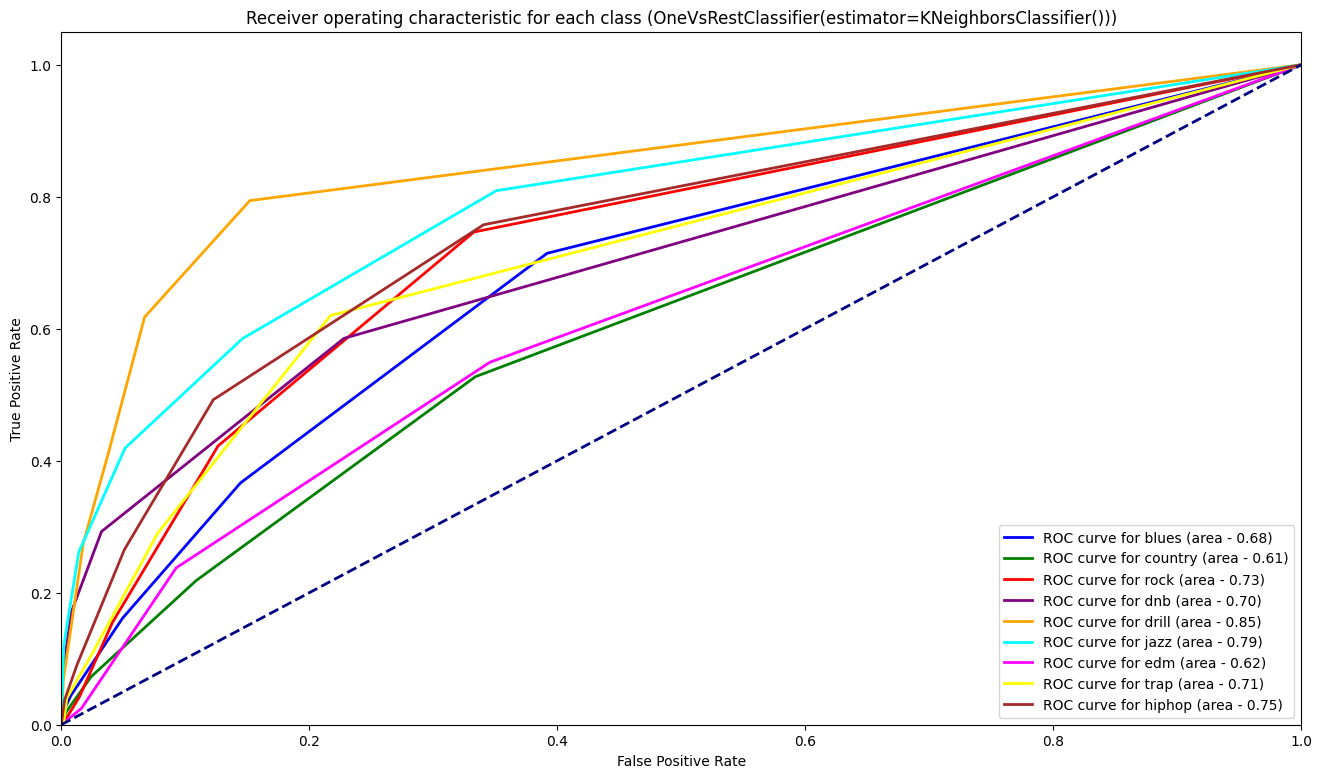

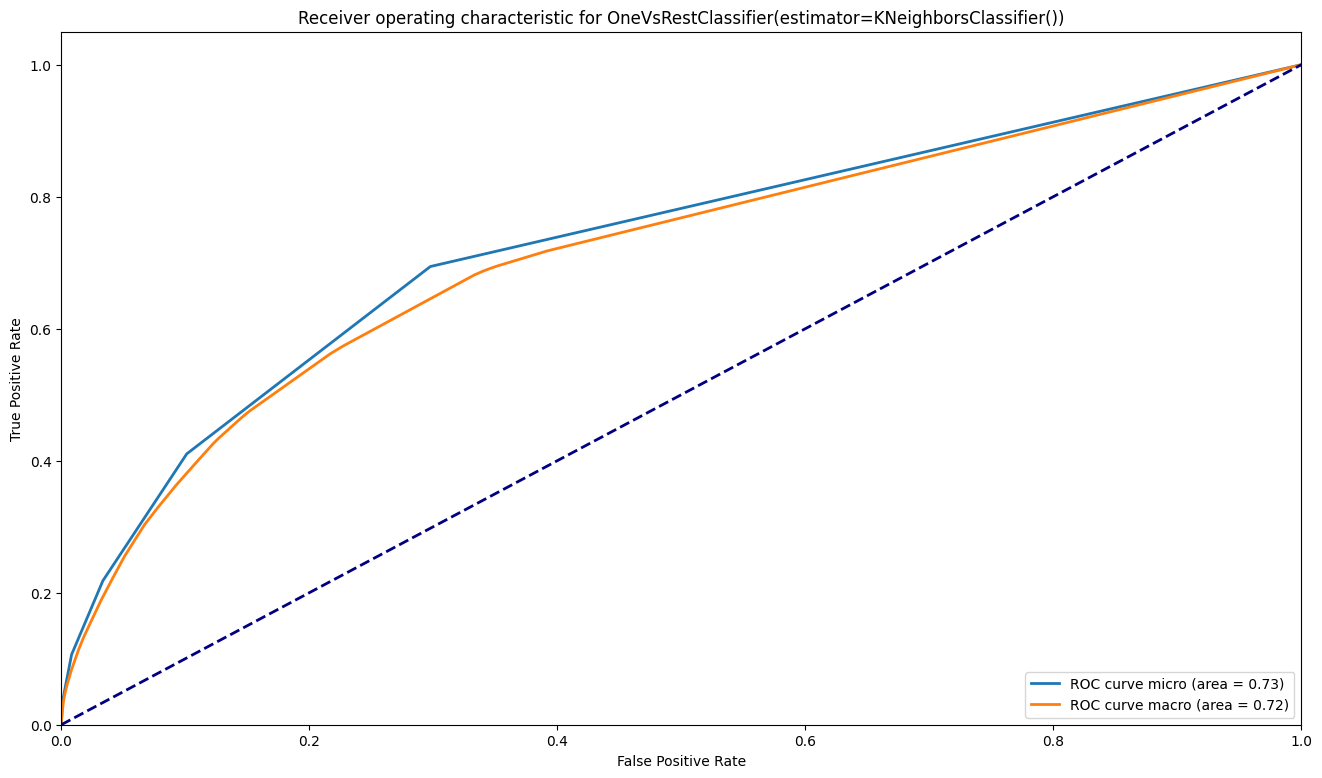

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


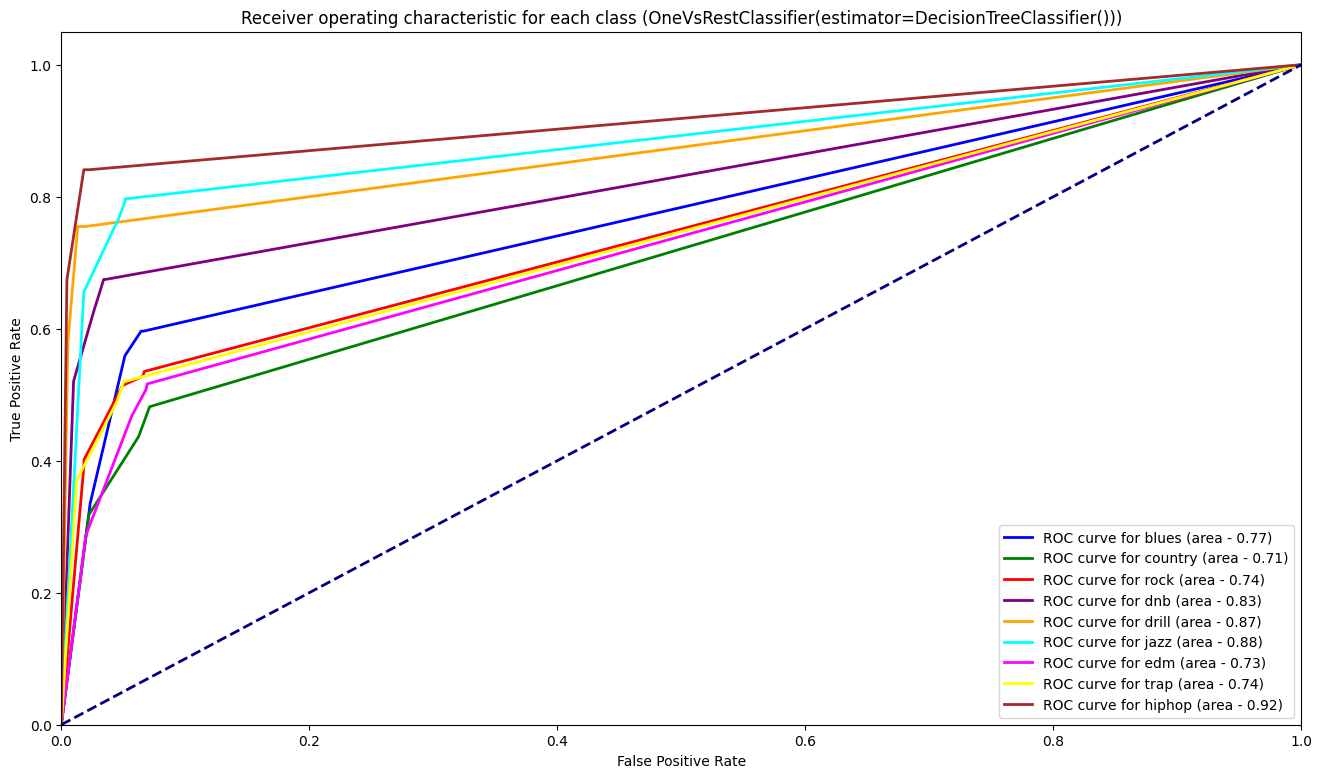

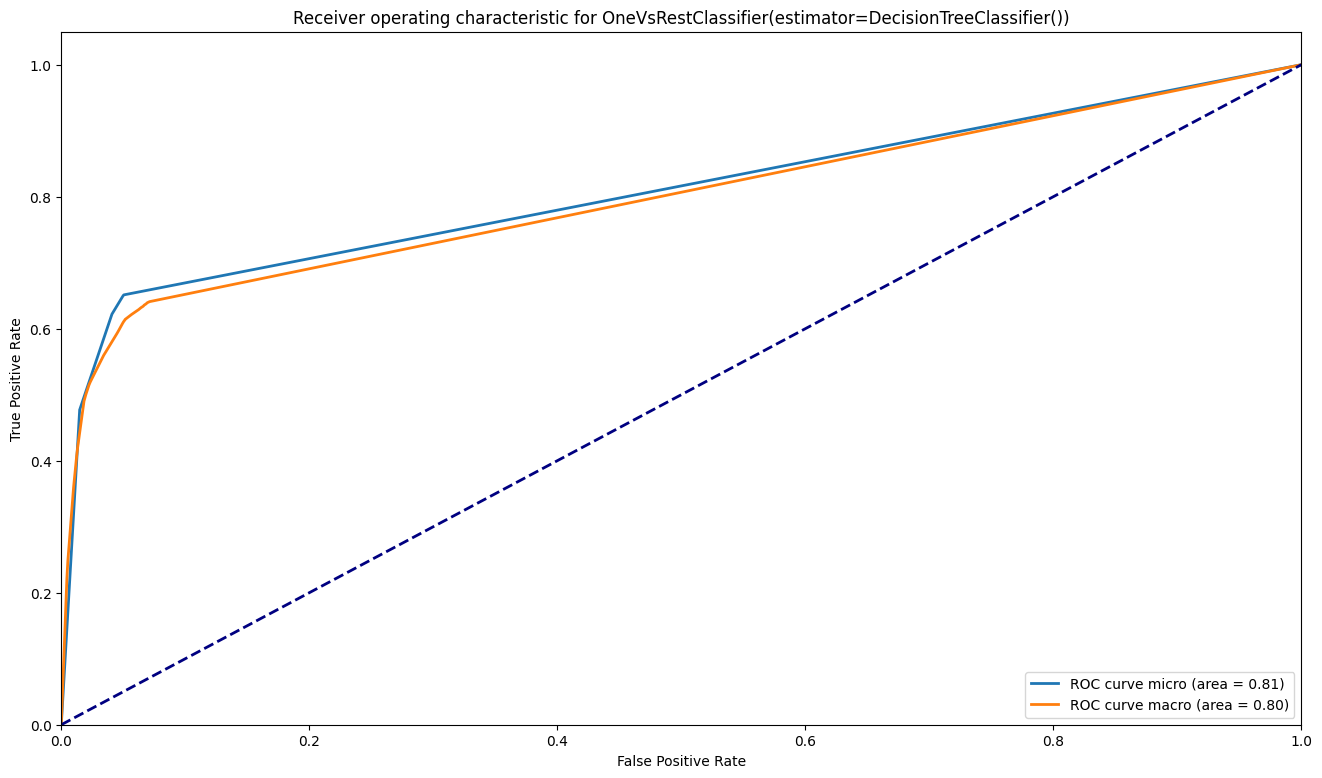

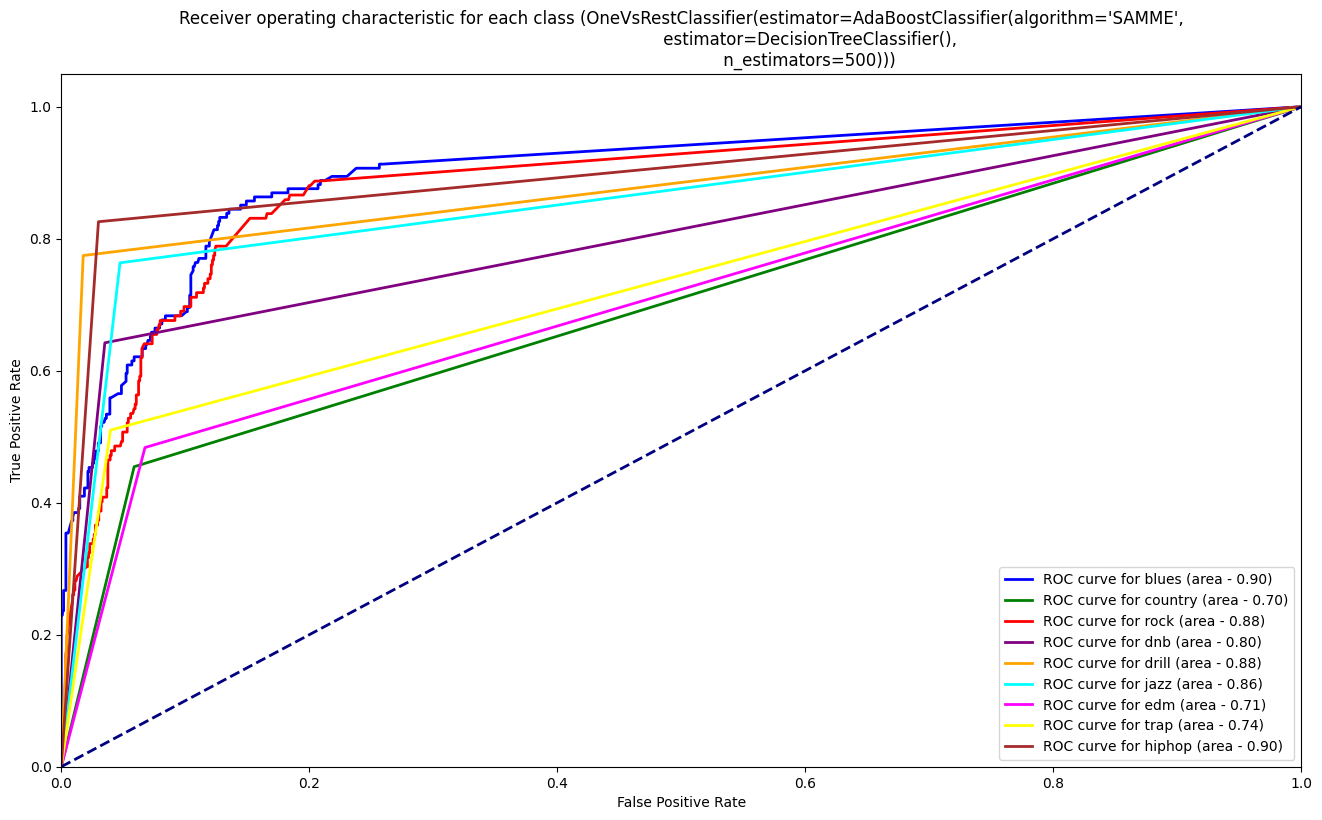

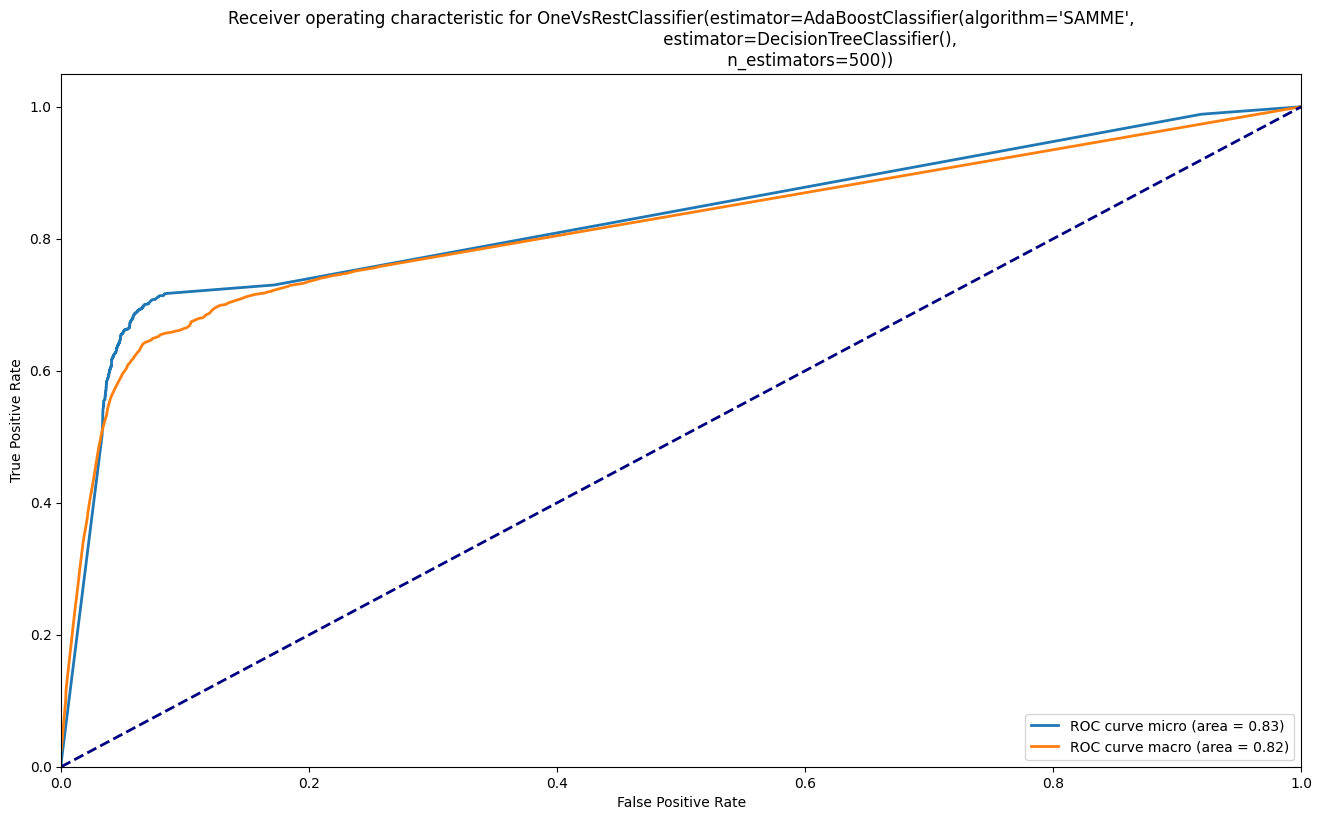

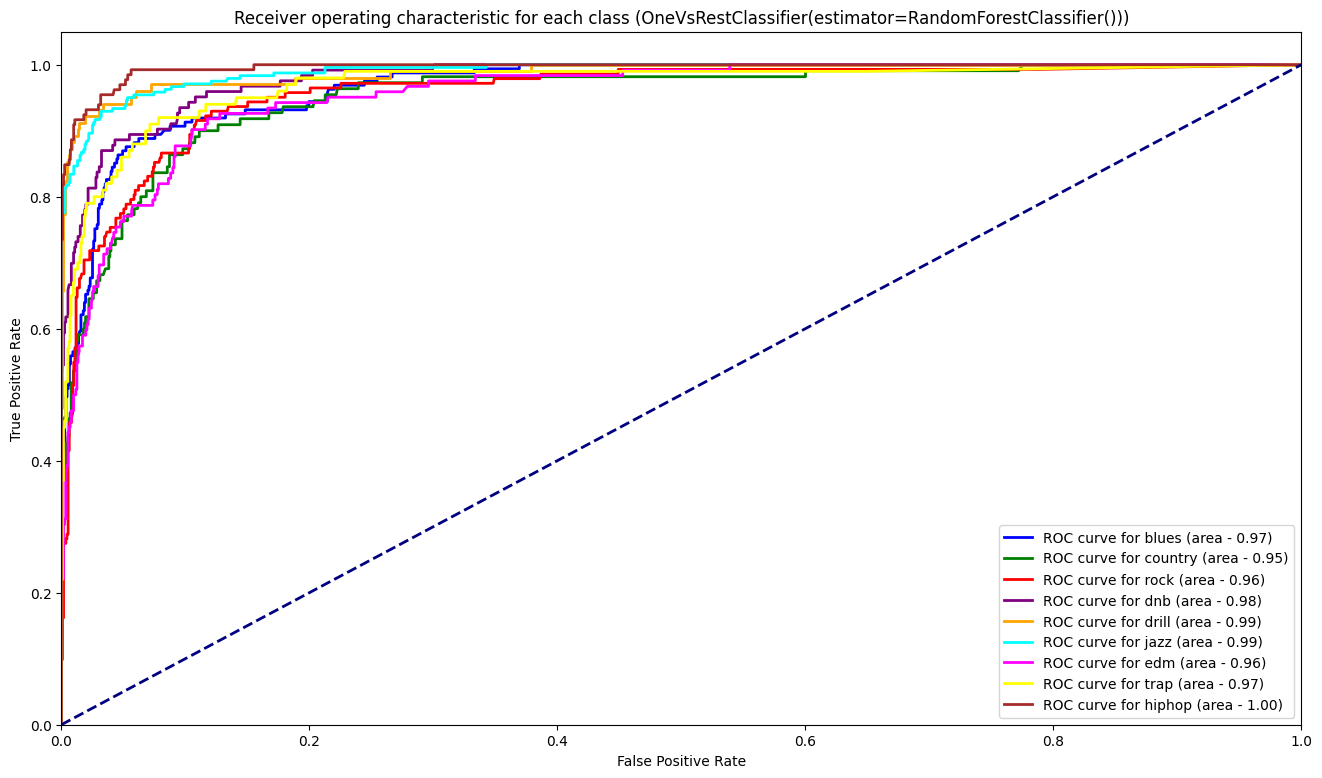

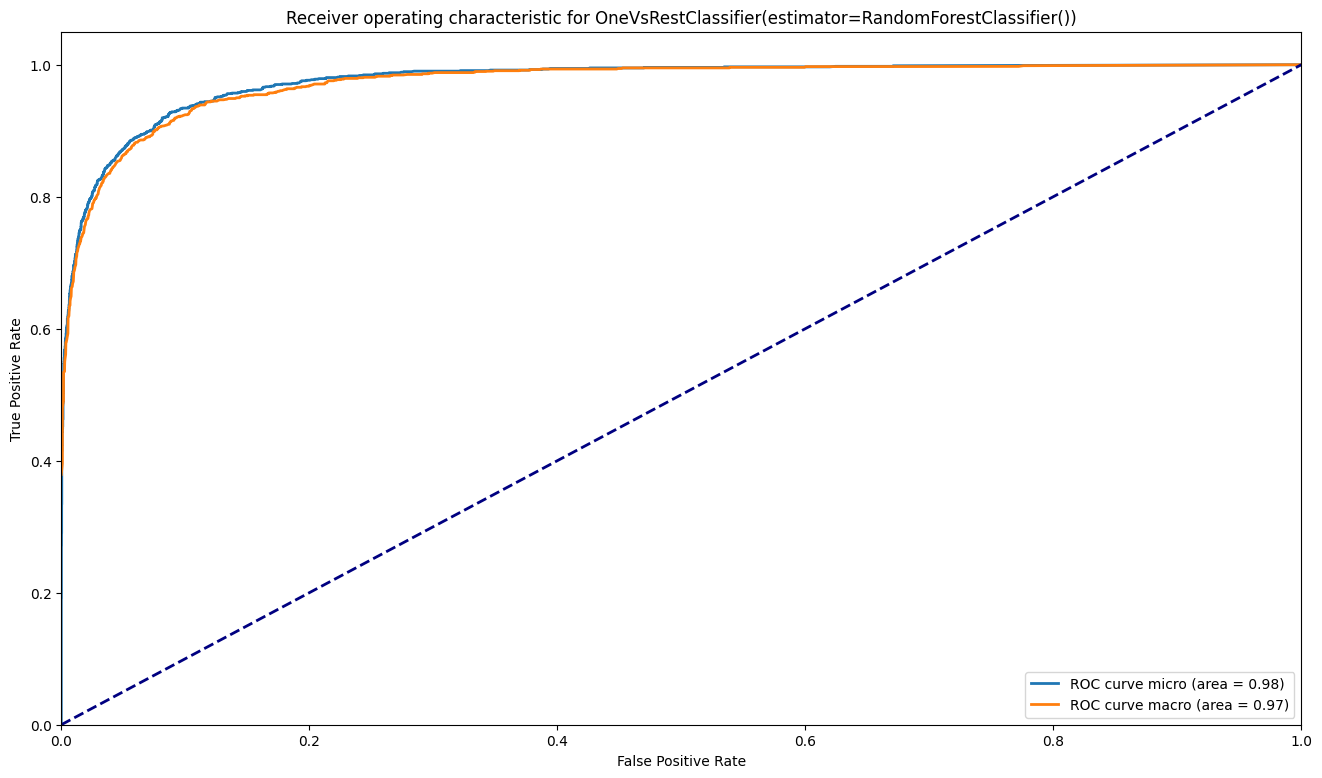

In [115]:
classifers_list = [
    "ovr_ridge_classifier",
    'ovr_svm_classifier',
    'ovr_knn_classifier',
    'ovr_dt_classifier',
    'ovr_adaBoost_classifier',
    'ovr_rf_classifier',
]

for clf in classifers_list:
  clf = analyze_classifier(eval(f"{clf}"), X_test_prepared, y_test)
  # clf.plot_precision_recall_micro() # rapporto precision-recall medio: > angolo retto curva, migliore è il modello
  # clf.plot_precision_recall_classes() # rapporto precision-recall per ogni classe
  clf.plot_roc_classes()
  clf.plot_roc_micro_macro()





## Cross Validation

For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.

## Random Forest using cross-validation

In [118]:
tic = time.time()
ovr_rf_cv_classifier = OneVsRestClassifier(RandomForestClassifier()) # n_estimators = 100 (default)
ovr_rf_cv_classifier.fit(X_train_prepared, y_train)
rf_cv_y_score = cross_val_predict(ovr_rf_cv_classifier, X_test_prepared, y_test, cv=5, method="predict_proba")
rf_cv_y_pred = np.argmax(rf_cv_y_score, axis=1)
toc = time.time()
rf_time = round(toc - tic, 2)


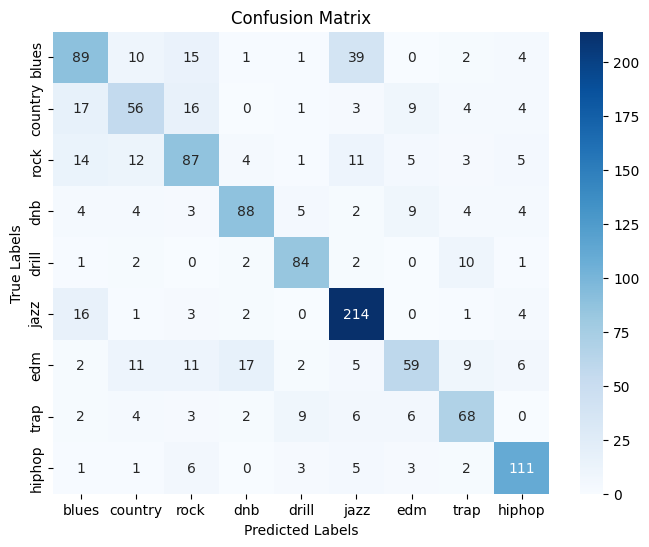

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       161
           1       0.55      0.51      0.53       110
           2       0.60      0.61      0.61       142
           3       0.76      0.72      0.74       123
           4       0.79      0.82      0.81       102
           5       0.75      0.89      0.81       241
           6       0.65      0.48      0.55       122
           7       0.66      0.68      0.67       100
           8       0.80      0.84      0.82       132

    accuracy                           0.69      1233
   macro avg       0.69      0.68      0.68      1233
weighted avg       0.69      0.69      0.69      1233



In [119]:
rf_cv_train_cm = confusion_matrix(y_test, rf_cv_y_pred)
plot_confusion_matrix(rf_cv_train_cm)
print(classification_report(y_test, rf_cv_y_pred))

# Analyze the most significant variables for each classifier

## Random Forest

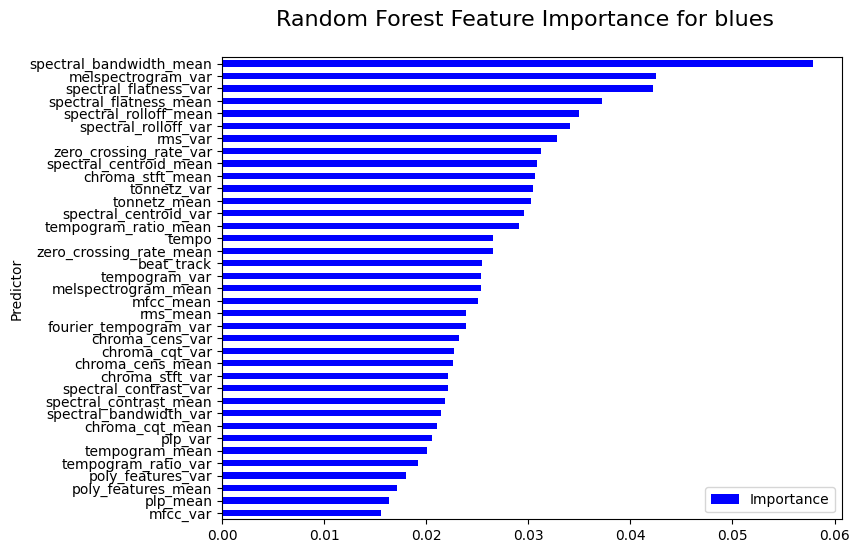

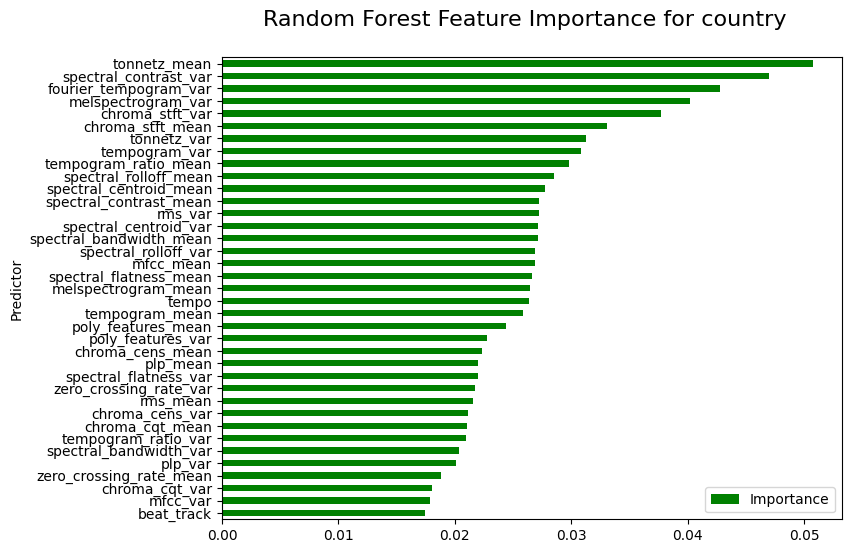

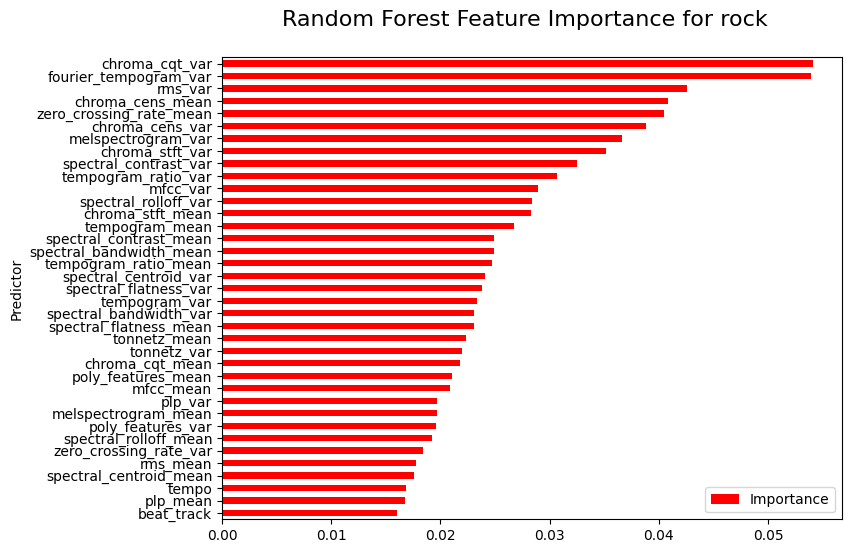

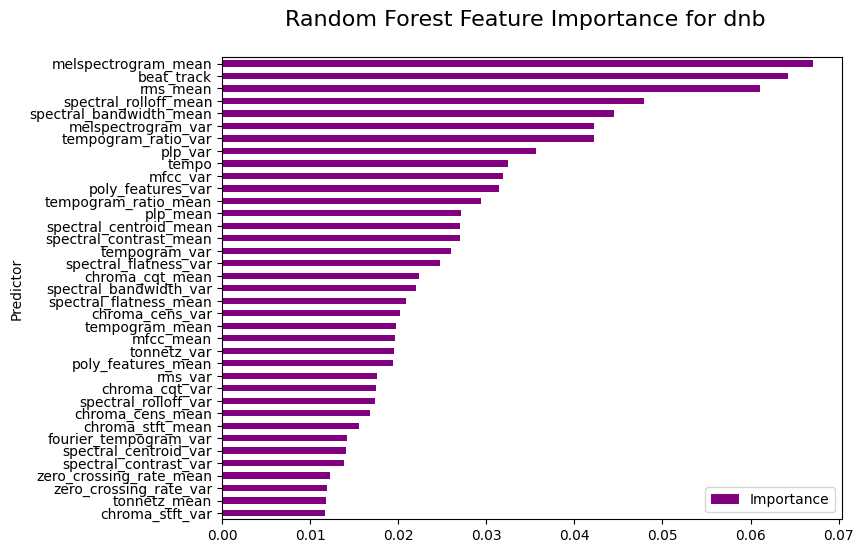

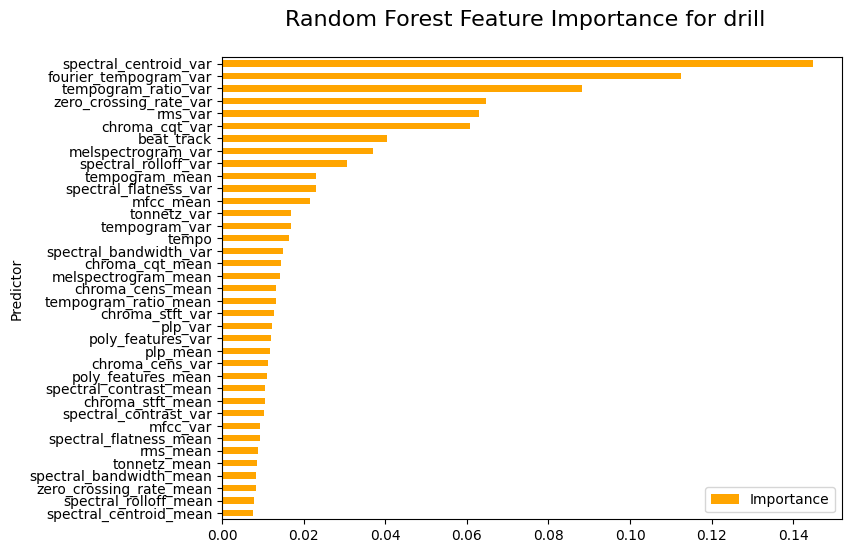

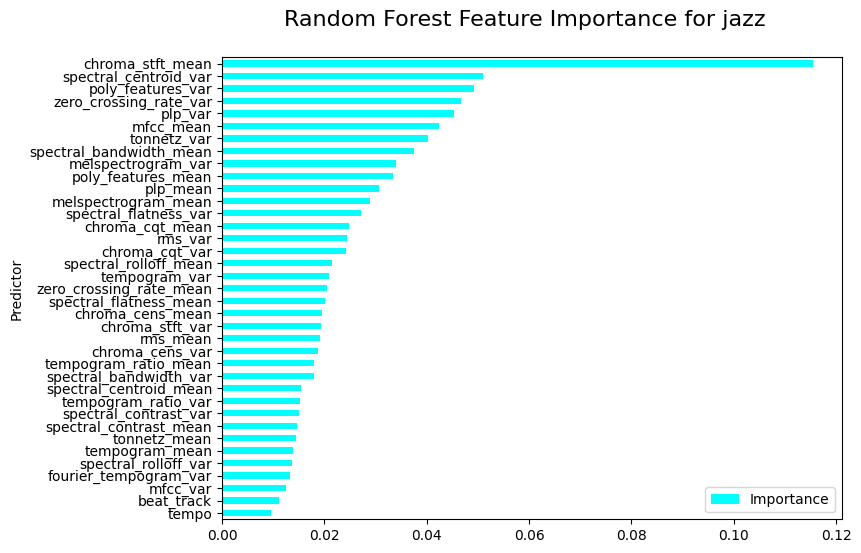

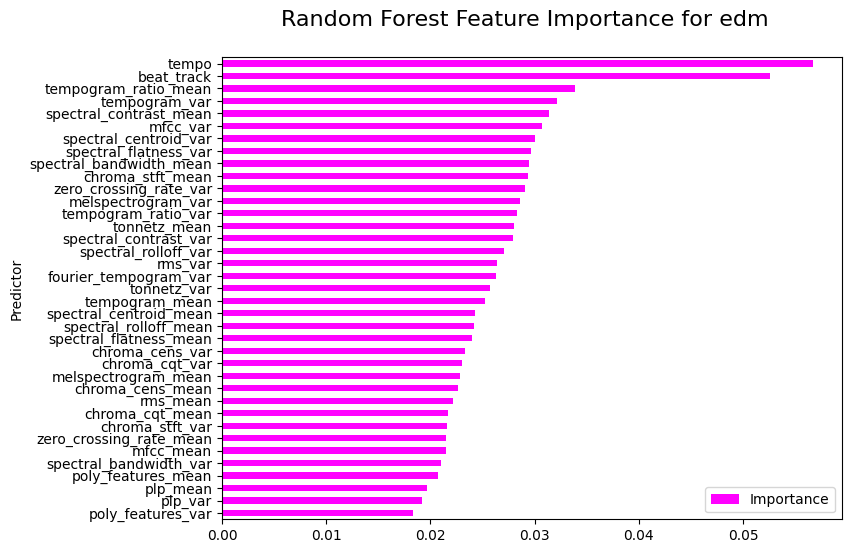

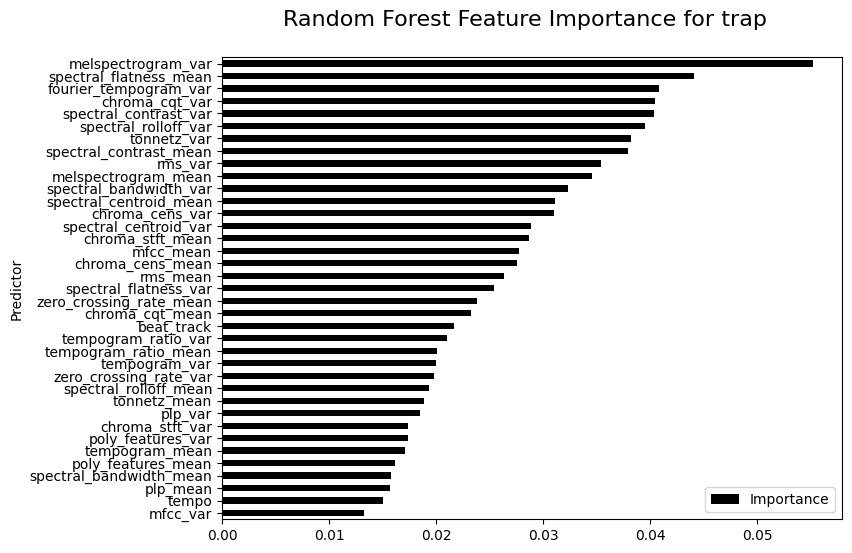

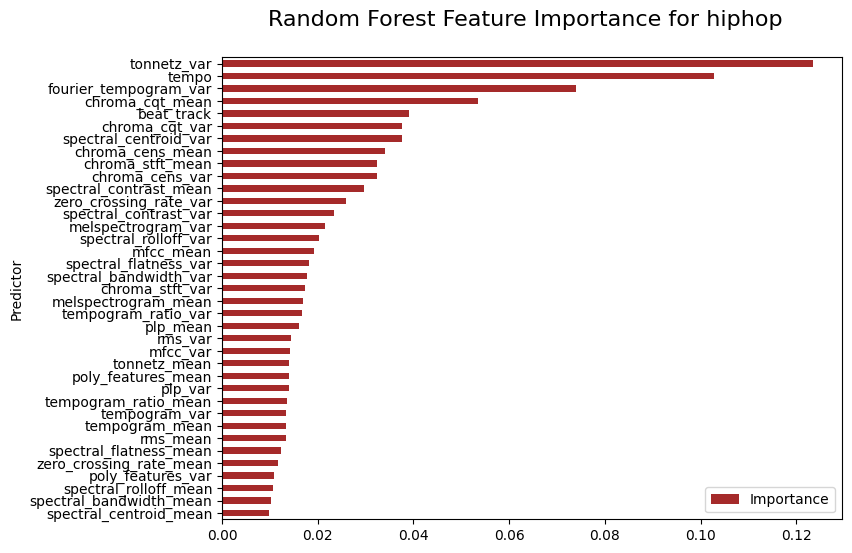

In [145]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black', 'brown']

for i in range(9):
    rf_features = pd.DataFrame({'Importance': ovr_rf_classifier.estimators_[i].feature_importances_, 'Predictor': X.columns})
    rf_features = rf_features.sort_values(by="Importance", ascending=True)

    rf_features.plot(kind="barh", x='Predictor', y='Importance', figsize=(8, 6), color=colors[i])

    plt.title(f'Random Forest Feature Importance for {genre_labels[i]}  \n', fontsize=16)
    plt.show()


In [159]:
# Crea un DataFrame vuoto per tenere traccia dei predittori e del loro conteggio
feature_count_df = pd.DataFrame(columns=['Predictor', 'Count'])

# Ciclo attraverso i classificatori
for i in range(9):
    rf_features = pd.DataFrame({'Importance': ovr_rf_classifier.estimators_[i].feature_importances_, 'Predictor': X.columns})
    rf_features = rf_features.sort_values(by="Importance", ascending=False)

    # Estrai i primi 10 predittori per questo classificatore
    top_features = rf_features.head(10)['Predictor'].tolist()

    # Ciclo attraverso i predittori di questo classificatore
    for feature in top_features:
        if feature in feature_count_df['Predictor'].values:
            # Se il predittore è già presente, incrementa il conteggio
            feature_count_df.loc[feature_count_df['Predictor'] == feature, 'Count'] += 1
        else:
            # Se il predittore è nuovo, aggiungilo con conteggio 1
            new_row = pd.DataFrame({'Predictor': [feature], 'Count': [1]})
            feature_count_df = pd.concat([feature_count_df, new_row], ignore_index=True)

# Ordina il DataFrame per il conteggio in ordine decrescente
feature_count_df = feature_count_df.sort_values(by='Count', ascending=False, ignore_index=True)

# Stampa il DataFrame con i predittori e il loro conteggio
print(feature_count_df)

                  Predictor Count
0        melspectrogram_var     7
1          chroma_stft_mean     5
2     fourier_tempogram_var     5
3   spectral_bandwidth_mean     4
4     spectral_centroid_var     4
5                beat_track     4
6               tonnetz_var     4
7            chroma_cqt_var     4
8                   rms_var     4
9       tempogram_ratio_var     3
10    spectral_contrast_var     3
11                    tempo     3
12     spectral_rolloff_var     3
13    spectral_rolloff_mean     3
14   zero_crossing_rate_var     3
15          chroma_cens_var     2
16                 mfcc_var     2
17                  plp_var     2
18   spectral_flatness_mean     2
19      melspectrogram_mean     2
20         chroma_cens_mean     2
21     tempogram_ratio_mean     2
22            tempogram_var     2
23          chroma_stft_var     2
24   spectral_contrast_mean     2
25    spectral_flatness_var     2
26       poly_features_mean     1
27        poly_features_var     1
28            

# Analyze the types of errors the models make.

# Perform a quick round of feature selection and engineering.

# Shortlist the top three to five most promising models, preferring models that make different types of errors.

# Fine-Tune the System

## Fine-tune the hyperparameters using cross-validation.

* Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you are not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
* Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors).

Per avere una visione più completa del modello, utlizziamo la funzione GridSearhCV di sklearn per l'ottimizzazione dei parametri.

In [165]:
# param_grid = [
#   {'estimator__n_estimators': [100, 500, 1000], 'estimator__max_depth': [5,10]},
#   {'estimator__bootstrap': [True]}
# ]

param_grid = {
  'estimator__n_estimators': [100, 500, 1000],
  'estimator__max_depth': [None,5,10],
  'estimator__bootstrap': [True, False],
}

scores = [
    'accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro'
]

global grid_search_models
global grid_search

grid_search_models = {}
for score in scores:
  print(f"Score: {score}")
  grid_search = GridSearchCV(
      ovr_rf_classifier,
      param_grid=param_grid,
      cv=2,
      scoring=score,
      refit=True
  )
  grid_search.fit(X_test_prepared, y_test)
  grid_search_models[score]=grid_search



Score: accuracy
Score: precision_macro
Score: recall_macro
Score: f1_macro


In [166]:
# Apri un file in modalità di scrittura
with open('grid_search_results.txt', 'w') as file:
    for key in grid_search_models.keys():
        file.write("\n" + "="*80 + "\n")
        file.write(f'Model: {key}\n')
        file.write('Best score: ' + str(round(grid_search_models[key].best_score_, 2)) + '\n')
        file.write('Best parameters: ' + str(grid_search_models[key].best_params_) + '\n')
        file.write('Best model: ' + str(grid_search_models[key].best_estimator_) + '\n')
        cv_res = grid_search_models[key].cv_results_
        file.write("\nCross validation results:\n")
        for mean_score, std_score, param in zip(cv_res["mean_test_score"], cv_res["std_test_score"], cv_res["params"]):
            file.write(f"Mean score: {round(mean_score,2)}, Std score: {round(std_score,2)}, Parameters: {param}\n")

# Chiudi il file
file.close()



Model: accuracy
Best score: 0.68
Best parameters: {'estimator__bootstrap': False, 'estimator__max_depth': None, 'estimator__n_estimators': 500}
Best model: OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                     n_estimators=500))

Cross validation results:
Mean score: 0.66, Std score: 0.01, Parameters: {'estimator__bootstrap': True, 'estimator__max_depth': None, 'estimator__n_estimators': 100}
Mean score: 0.67, Std score: 0.0, Parameters: {'estimator__bootstrap': True, 'estimator__max_depth': None, 'estimator__n_estimators': 500}
Mean score: 0.67, Std score: 0.01, Parameters: {'estimator__bootstrap': True, 'estimator__max_depth': None, 'estimator__n_estimators': 1000}
Mean score: 0.62, Std score: 0.01, Parameters: {'estimator__bootstrap': True, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}
Mean score: 0.63, Std score: 0.0, Parameters: {'estimator__bootstrap': True, 'estimator__max_depth': 5, 'estimator__n

## Try Ensemble methods. Combining your best models will often produce better performance than running them individually.

## Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

In [171]:
print(models_performances_sorted.shape)
print(models_performances_sorted.keys)

print(perc_svm)


(8, 3)
<bound method NDFrame.keys of                  Model  Accuracy   Time
4       rf_classifier       0.74  57.27
7        rf_classifier      0.74  80.53
2       knn_classifier      0.73   0.30
1       svm_classifier      0.73   0.52
0     ridge_classifier      0.66   0.06
6        dt_classifier      0.40   2.43
5  adaBoost_classifier      0.38   1.01
3       dt_classifier       0.37   0.91>
0.73


# Try the models with any songs

In [74]:
import ipywidgets as widgets
from pytube.contrib.playlist import YouTube
import time
from collections import Counter

# Define the list of classifiers
perc_ridge = models_performances_sorted.loc[models_performances_sorted['Model'] == 'ridge_classifier', 'Accuracy'].iloc[0]
perc_svm = models_performances_sorted.loc[models_performances_sorted['Model'] == 'svm_classifier', 'Accuracy'].iloc[0]
perc_knn = models_performances_sorted.loc[models_performances_sorted['Model'] == 'knn_classifier', 'Accuracy'].iloc[0]
perc_ada = models_performances_sorted.loc[models_performances_sorted['Model'] == 'adaBoost_classifier', 'Accuracy'].iloc[0]
perc_dt = models_performances_sorted.loc[models_performances_sorted['Model'] == 'dt_classifier', 'Accuracy'].iloc[0]
perc_rf = models_performances_sorted.loc[models_performances_sorted['Model'] == 'rf_classifier', 'Accuracy'].iloc[0]

classifiers_list = [
    f"ovr_ridge_classifier ({perc_ridge} acc.)",
    f'ovr_svm_classifier ({perc_svm} acc.)',
    f'ovr_knn_classifier ({perc_knn} acc.)',
    f'ovr_dt_classifier ({perc_dt} acc.)',
    f'ovr_rf_classifier ({perc_rf} acc.)',
    f'ovr_adaBoost_classifier ({perc_ada} acc.)'
]

yt_song_url = 'https://www.youtube.com/watch?v=GTWqwSNQCcg' # @param {type:"string"}


def get_features_from_30_sec(genre, file_path):
    y, sr = librosa.load(file_path)

    # Calculate the length of the audio file in seconds
    length = np.shape(y)[0]

    # Extract the features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    beat_track, _ = librosa.beat.beat_track(y=y, sr=sr)
    plp = librosa.feature.poly_features(y=y, sr=sr)
    onset_detect = librosa.onset.onset_detect(y=y, sr=sr)
    tempo = librosa.feature.tempo(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)
    tempogram_ratio = librosa.feature.tempogram_ratio(y=y, sr=sr)

    # Create a dictionary to store the features
    features = pd.DataFrame({
            'title': [str(file_path).split('/')[-1].split('.')[0]],
            'chroma_stft_mean': [np.mean(chroma_stft)],
            'chroma_cqt_mean': [np.mean(chroma_cqt)],
            'chroma_cens_mean': [np.mean(chroma_cens)],
            'melspectrogram_mean': [np.mean(melspectrogram)],
            'mfcc_mean': [np.mean(mfcc)],
            'rms_mean': [np.mean(rms)],
            'spectral_centroid_mean': [np.mean(spectral_centroid)],
            'spectral_bandwidth_mean': [np.mean(spectral_bandwidth)],
            'spectral_contrast_mean': [np.mean(spectral_contrast)],
            'spectral_flatness_mean': [np.mean(spectral_flatness)],
            'spectral_rolloff_mean': [np.mean(spectral_rolloff)],
            'poly_features_mean': [np.mean(poly_features)],
            'tonnetz_mean': [np.mean(tonnetz)],
            'zero_crossing_rate_mean': [np.mean(zero_crossing_rate)],
            'plp_mean': [np.mean(plp)],
            'tempogram_mean': [np.mean(tempogram)],
            'tempogram_ratio_mean':[np.mean(tempogram_ratio)],
            'chroma_stft_var': [np.var(chroma_stft)],
            'chroma_cqt_var': [np.var(chroma_cqt)],
            'chroma_cens_var': [np.var(chroma_cens)],
            'melspectrogram_var': [np.var(melspectrogram)],
            'mfcc_var': [np.var(mfcc)],
            'rms_var': [np.var(rms)],
            'spectral_centroid_var': [np.var(spectral_centroid)],
            'spectral_bandwidth_var': [np.var(spectral_bandwidth)],
            'spectral_contrast_var': [np.var(spectral_contrast)],
            'spectral_flatness_var': [np.var(spectral_flatness)],
            'spectral_rolloff_var': [np.var(spectral_rolloff)],
            'poly_features_var': [np.var(poly_features)],
            'tonnetz_var': [np.var(tonnetz)],
            'zero_crossing_rate_var': [np.var(zero_crossing_rate)],
            'beat_track': [beat_track],
            'plp_var': [np.var(plp)],
            'tempo': [tempo[0]],
            'tempogram_var': [np.var(tempogram)],
            'fourier_tempogram_var':[np.var(fourier_tempogram)],
            'tempogram_ratio_var':[np.var(tempogram_ratio)],
            'length':[length],
            'genre': [genre]
        })


    return features


def split_audio(segment_duration, file_path, output_folder, filename):
  # Carica il file audio
  audio = AudioSegment.from_file(file_path)

  os.makedirs(output_folder, exist_ok=True)

  # Divide il file audio in segmenti e salva le divisioni
  for i, start in enumerate(range(0, len(audio), segment_duration)):
      segment = audio[start:start + segment_duration]
      output_path = os.path.join(output_folder, f'{filename}_{i + 1}.wav')
      segment.export(output_path, format='wav')
      # print(f'Saved segment {i + 1} to {output_path}')


def download_song_and_predict(yt_song_url, classifier_name):
    # Get the selected classifier
    selected_classifier = globals()[classifier_name]

    yt = YouTube(yt_song_url)
    try:
        audio_stream = yt.streams.get_audio_only()
        print("Downloading the audio...")
        audio_file = audio_stream.download(filename=yt.title+".wav")
        print("Splitting the audio into 30 sec segments")
        split_audio(30000, file_path=f"{yt.title}.wav", output_folder="/content/drive/MyDrive/MusicGenreClassification/song_segments", filename=yt.title)
        file_count = sum(1 for _ in os.listdir("/content/drive/MyDrive/MusicGenreClassification/song_segments") if _.endswith('.wav'))
        print(f"{file_count} segments have been created")
    except exceptions.AgeRestrictedError as e:
        print(f'Error: {e}. Skipping video...')
        return
    except Exception as e:
        print(f'Error: {e}. Skipping video...')
        return
    print("Extracting features...")

    seg_pred_df = pd.DataFrame(columns=['Segment', 'Predicted genre'])
    features_df = pd.DataFrame(columns=selected_features)
    count=0
    for s in os.listdir('/content/drive/MyDrive/MusicGenreClassification/song_segments'):
        if s.endswith('.wav'):
            if count != 0:
              # print(f"\tExtracting features from {s}...")
              audio_features = get_features_from_30_sec("unknown", os.path.join('/content/drive/MyDrive/MusicGenreClassification/song_segments', s))
              selected_audio_features = audio_features[selected_features]
              if scale_features == False:
                selected_audio_features = selected_audio_features.values
              if scale_features == True:
                # print("\t\tFeatures scaling...")
                if selected_scaling_mode == 'Standardization':
                  scaler = StandardScaler()
                elif selected_scaling_mode == 'Normalization':
                  scaler = MinMaxScaler()
                else:
                  print("Please run the 'Features scaling' section again")

                selected_audio_features = scaler.fit_transform(selected_audio_features)

              genre_pred = selected_classifier.predict(selected_audio_features)
              predicted_genre = genre_labels[genre_pred[0]]
              new_row = {'Segment': [s], 'Predicted genre': [predicted_genre]}
              new_row_df = pd.DataFrame(new_row)
              seg_pred_df = pd.concat([seg_pred_df, new_row_df], ignore_index=True)
            # else:
              # print(f"\tDiscarting {s} (intro)...")
        count=count+1

    print(seg_pred_df)

    genre_counts = Counter(seg_pred_df['Predicted genre'])

    # # Find the genre with the highest frequency
    most_common_genre = genre_counts.most_common(1)[0][0]

    print(f"\nThe predicted genre with the highest frequency is: {most_common_genre}\n")
    print("="*80)
    !rm -r "/content/drive/MyDrive/MusicGenreClassification/song_segments"
    !rm -r yt.title+".wav"

classifier_choice = widgets.Dropdown(options=classifiers_list, description='Classifier:')
display(classifier_choice)

# Add an "Run" button for user interaction
run_button = widgets.Button(description="Run")
display(run_button)

def on_run_button_click(b):
  print("="*80)
  selected_classifier = classifier_choice.value.split(" (")[0]
  download_song_and_predict(yt_song_url, selected_classifier)

run_button.on_click(on_run_button_click)


Dropdown(description='Classifier:', options=('ovr_ridge_classifier (0.61 acc.)', 'ovr_svm_classifier (0.38 acc…

Button(description='Run', style=ButtonStyle())

Splitting the audio into 30 sec segments
5 segments have been created
Extracting features...
               Segment Predicted genre
0  City of Stars_2.wav           blues
1  City of Stars_3.wav         country
2  City of Stars_4.wav           blues
3  City of Stars_5.wav           blues

The predicted genre with the highest frequency is: blues

rm: cannot remove 'yt.title+.wav': No such file or directory
